In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [9]:
import pandas as pd
import numpy as np
from datetime import datetime

def parse_hurdat_to_dataframe(hurdat_filepath):
    """
    HURDAT2 formatındaki bir dosyayı okur ve temel kasırga bilgilerini
    içeren bir Pandas DataFrame'e dönüştürür.

    Args:
        hurdat_filepath (str): HURDAT2 .txt dosyasının yolu.

    Returns:
        pandas.DataFrame: İşlenmiş kasırga verilerini içeren DataFrame.
                          Eğer dosya okunamadıysa veya format hatası varsa boş DataFrame dönebilir.
    """
    records_list = []  # Her bir gözlem kaydını (dictionary) tutacak liste
    current_storm_id = None
    current_storm_name = None

    print(f"'{hurdat_filepath}' dosyası okunuyor...")
    try:
        with open(hurdat_filepath, 'r') as file:
            for line_number, line in enumerate(file, 1):
                line = line.strip()
                if not line:
                    continue

                parts = [p.strip() for p in line.split(',')]

                if len(parts) >= 3 and \
                   parts[0].startswith(('AL', 'EP', 'CP')) and \
                   len(parts[0]) >= 8 and \
                   parts[0][2:4].isdigit() and \
                   parts[0][4:8].isdigit():
                    try:
                        num_entries_check = int(parts[2]) 
                        current_storm_id = parts[0]
                        current_storm_name = parts[1]
                        if not current_storm_name: 
                            current_storm_name = "UNNAMED"
                        continue 
                    except ValueError:
                        pass
                
                if current_storm_id and len(parts) >= 8:
                    date_str = parts[0]
                    time_str = parts[1]
                    
                    try:
                        year = int(date_str[:4])
                        month = int(date_str[4:6])
                        day = int(date_str[6:8])
                        hour = int(time_str[:2])
                        minute = int(time_str[2:])
                        timestamp = datetime(year, month, day, hour, minute)
                    except ValueError:
                        print(f"  Uyarı (Satır {line_number}): Hatalı tarih/saat formatı atlanıyor: '{date_str} {time_str}' for Storm ID: {current_storm_id}")
                        continue 

                    record_identifier = parts[2] 
                    system_status = parts[3]    
                    
                    lat_str = parts[4]
                    lon_str = parts[5]
                    
                    try:
                        lat = float(lat_str[:-1]) 
                        if lat_str.endswith('S'):
                            lat *= -1
                        
                        lon = float(lon_str[:-1]) 
                        if lon_str.endswith('W'):
                            lon *= -1
                    except ValueError:
                        print(f"  Uyarı (Satır {line_number}): Hatalı enlem/boylam formatı atlanıyor: '{lat_str} {lon_str}' for Storm ID: {current_storm_id}")
                        continue
                    
                    try:
                        max_wind_knots_str = parts[6]
                        max_wind_knots = int(max_wind_knots_str) if max_wind_knots_str and int(max_wind_knots_str) != -99 else np.nan
                        
                        min_pressure_mb_str = parts[7]
                        min_pressure_mb = int(min_pressure_mb_str) if min_pressure_mb_str and int(min_pressure_mb_str) != -999 else np.nan
                    except ValueError:
                        print(f"  Uyarı (Satır {line_number}): Hatalı VMAX/MSLP formatı atlanıyor: '{parts[6]}' '{parts[7]}' for Storm ID: {current_storm_id}")
                        max_wind_knots = np.nan
                        min_pressure_mb = np.nan
                    except IndexError: 
                        print(f"  Uyarı (Satır {line_number}): VMAX/MSLP için eksik sütunlar, satır atlanıyor. Storm ID: {current_storm_id}")
                        max_wind_knots = np.nan
                        min_pressure_mb = np.nan

                    records_list.append({
                        'STORM_ID': current_storm_id,
                        'STORM_NAME': current_storm_name,
                        'TIMESTAMP': timestamp,
                        'RECORD_ID': record_identifier,
                        'STATUS': system_status,
                        'LAT': lat,
                        'LON': lon,
                        'VMAX_current': max_wind_knots,
                        'MSLP_current': min_pressure_mb
                    })
                        
    except FileNotFoundError:
        print(f"HATA: '{hurdat_filepath}' dosyası bulunamadı. Lütfen dosya yolunu kontrol edin.")
        return pd.DataFrame() 
    except Exception as e:
        print(f"Dosya okunurken veya işlenirken bir hata oluştu: {e}")
        return pd.DataFrame()

    if not records_list:
        print("Uyarı: Dosyadan hiçbir kayıt okunamadı veya işlenemedi.")
        return pd.DataFrame()
        
    df = pd.DataFrame(records_list)
    if 'TIMESTAMP' in df.columns:
        df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
    
    print(f"Dosya okuma ve temel ayrıştırma tamamlandı. Toplam {len(df)} kayıt oluşturuldu.")
    return df

# --- Ana İş Akışı (Adım 1) ---
if __name__ == "__main__":
    # LÜTFEN İNDİRDİĞİNİZ HURDAT2 DOSYASININ ADINI VE YOLUNU BURAYA GÜNCELLEYİN
    hurdat_file_path = './DATAS/hurdat2_atlantic.txt' # Örnek dosya adı

    print("--- Adım 1: HURDAT2 Ham Verisini Okuma ve Temel DataFrame Oluşturma ---")
    df_hurdat_step1 = parse_hurdat_to_dataframe(hurdat_file_path)

    if not df_hurdat_step1.empty:
        print("\nOluşturulan Temel DataFrame'in İlk 5 Satırı:")
        print(df_hurdat_step1.head())
        
        print("\nDataFrame Bilgileri:")
        df_hurdat_step1.info()
        
        print("\nEksik Değerlerin Özeti (Her Sütun İçin):")
        print(df_hurdat_step1.isnull().sum())

        output_csv_filename_step1 = 'hurricanes_s1_base_data.csv'
        df_hurdat_step1.to_csv(output_csv_filename_step1, index=False)
        print(f"\nTemel DataFrame '{output_csv_filename_step1}' olarak kaydedildi.")
        print("--- Adım 1 Tamamlandı ---")
    else:
        print("Adım 1: DataFrame oluşturulamadı. Lütfen yukarıdaki hata mesajlarını kontrol edin.")

--- Adım 1: HURDAT2 Ham Verisini Okuma ve Temel DataFrame Oluşturma ---
'./DATAS/hurdat2_atlantic.txt' dosyası okunuyor...
Dosya okuma ve temel ayrıştırma tamamlandı. Toplam 55230 kayıt oluşturuldu.

Oluşturulan Temel DataFrame'in İlk 5 Satırı:
   STORM_ID STORM_NAME           TIMESTAMP RECORD_ID STATUS   LAT   LON  \
0  AL011851    UNNAMED 1851-06-25 00:00:00               HU  28.0 -94.8   
1  AL011851    UNNAMED 1851-06-25 06:00:00               HU  28.0 -95.4   
2  AL011851    UNNAMED 1851-06-25 12:00:00               HU  28.0 -96.0   
3  AL011851    UNNAMED 1851-06-25 18:00:00               HU  28.1 -96.5   
4  AL011851    UNNAMED 1851-06-25 21:00:00         L     HU  28.2 -96.8   

   VMAX_current  MSLP_current  
0          80.0           NaN  
1          80.0           NaN  
2          80.0           NaN  
3          80.0           NaN  
4          80.0           NaN  

DataFrame Bilgileri:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55230 entries, 0 to 55229
Data columns (

In [11]:
import pandas as pd
import numpy as np

# --- Fonksiyon: STORM_AGE_hours ve DAY_OF_YEAR ekleme ---
def add_storm_age_and_day_of_year(input_df):
    """
    DataFrame'i STORM_ID ve TIMESTAMP'e göre sıralar.
    DAY_OF_YEAR ve STORM_AGE_hours sütunlarını ekler.

    Args:
        input_df (pandas.DataFrame): Adım 1'den gelen temel kasırga DataFrame'i.

    Returns:
        pandas.DataFrame: Yeni sütunlar eklenmiş DataFrame.
    """
    df = input_df.copy() # Orijinal DataFrame üzerinde değişiklik yapmamak için kopyasını alalım

    # TIMESTAMP sütununun datetime tipinde olduğundan emin olalım (CSV'den okurken string olabilir)
    if not pd.api.types.is_datetime64_any_dtype(df['TIMESTAMP']):
        print("TIMESTAMP sütunu datetime formatına dönüştürülüyor...")
        df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])

    # Veriyi sırala: Bu, STORM_AGE ve sonraki adımlarda eklenecek lag'lı özellikler için çok önemlidir.
    print("DataFrame STORM_ID ve TIMESTAMP'e göre sıralanıyor...")
    df = df.sort_values(by=['STORM_ID', 'TIMESTAMP']).reset_index(drop=True)
    
    # DAY_OF_YEAR sütununu ekle
    print("DAY_OF_YEAR sütunu ekleniyor...")
    df['DAY_OF_YEAR'] = df['TIMESTAMP'].dt.dayofyear
    
    # STORM_AGE_hours sütununu ekle
    # Her fırtınanın ilk gözlem zamanından itibaren geçen süreyi saat cinsinden hesaplar.
    print("STORM_AGE_hours sütunu ekleniyor...")
    df['STORM_AGE_hours'] = df.groupby('STORM_ID')['TIMESTAMP'].transform(
        lambda x: (x - x.min()).dt.total_seconds() / 3600
    )
    
    print("STORM_AGE_hours ve DAY_OF_YEAR sütunları başarıyla eklendi.")
    return df

# --- Ana İş Akışı (Adım 2) ---
if __name__ == "__main__":
    input_csv_filename_step1 = 'hurricanes_s1_base_data.csv'
    output_csv_filename_step2 = 'hurricanes_s2_age_doy.csv'

    print("\n--- Adım 2: DataFrame'i Sıralama ve STORM_AGE_hours ile DAY_OF_YEAR Ekleme ---")
    try:
        print(f"'{input_csv_filename_step1}' yükleniyor...")
        df_step1_loaded = pd.read_csv(input_csv_filename_step1)
        
        df_step2_processed = add_storm_age_and_day_of_year(df_step1_loaded)

        if not df_step2_processed.empty:
            print("\nGüncellenmiş DataFrame'in İlk 5 Satırı (Yeni Sütunlarla Birlikte):")
            print(df_step2_processed.head())
            
            print("\nGüncellenmiş DataFrame'in Son 5 Satırı (Yeni Sütunlarla Birlikte):")
            print(df_step2_processed.tail())

            print("\nDataFrame Bilgileri (Yeni Sütunlarla):")
            df_step2_processed.info()
            
            # Yeni eklenen sütunların istatistiklerine hızlı bir bakış
            print("\nDAY_OF_YEAR İstatistikleri:")
            print(df_step2_processed['DAY_OF_YEAR'].describe())
            
            print("\nSTORM_AGE_hours İstatistikleri:")
            print(df_step2_processed['STORM_AGE_hours'].describe())

            df_step2_processed.to_csv(output_csv_filename_step2, index=False)
            print(f"\nGüncellenmiş DataFrame '{output_csv_filename_step2}' olarak kaydedildi.")
            print("--- Adım 2 Tamamlandı ---")
        else:
            print("Adım 2: DataFrame işlenemedi veya boş döndü.")

    except FileNotFoundError:
        print(f"HATA: '{input_csv_filename_step1}' dosyası bulunamadı. Lütfen Adım 1'in başarıyla tamamlandığından emin olun.")
    except Exception as e:
        print(f"Adım 2 sırasında bir hata oluştu: {e}")


--- Adım 2: DataFrame'i Sıralama ve STORM_AGE_hours ile DAY_OF_YEAR Ekleme ---
'hurricanes_s1_base_data.csv' yükleniyor...
TIMESTAMP sütunu datetime formatına dönüştürülüyor...
DataFrame STORM_ID ve TIMESTAMP'e göre sıralanıyor...
DAY_OF_YEAR sütunu ekleniyor...
STORM_AGE_hours sütunu ekleniyor...
STORM_AGE_hours ve DAY_OF_YEAR sütunları başarıyla eklendi.

Güncellenmiş DataFrame'in İlk 5 Satırı (Yeni Sütunlarla Birlikte):
   STORM_ID STORM_NAME           TIMESTAMP RECORD_ID STATUS   LAT   LON  \
0  AL011851    UNNAMED 1851-06-25 00:00:00       NaN     HU  28.0 -94.8   
1  AL011851    UNNAMED 1851-06-25 06:00:00       NaN     HU  28.0 -95.4   
2  AL011851    UNNAMED 1851-06-25 12:00:00       NaN     HU  28.0 -96.0   
3  AL011851    UNNAMED 1851-06-25 18:00:00       NaN     HU  28.1 -96.5   
4  AL011851    UNNAMED 1851-06-25 21:00:00         L     HU  28.2 -96.8   

   VMAX_current  MSLP_current  DAY_OF_YEAR  STORM_AGE_hours  
0          80.0           NaN          176              0.0

In [13]:
import pandas as pd
import numpy as np

# --- Fonksiyon: Geçmiş VMAX ve DELV (VMAX Değişimi) ekleme ---
def add_lagged_vmax_and_deltas(input_df):
    """
    DataFrame'e geçmiş VMAX değerlerini (VMAX_prev_Xhr) ve
    VMAX değişimlerini (DELV_Xhr) ekler.
    DataFrame'in zaten STORM_ID ve TIMESTAMP'e göre sıralı olduğu varsayılır.

    Args:
        input_df (pandas.DataFrame): Adım 2'den gelen DataFrame.

    Returns:
        pandas.DataFrame: Yeni sütunlar eklenmiş DataFrame.
    """
    df = input_df.copy() # Orijinal DataFrame üzerinde değişiklik yapmamak için kopyasını alalım

    # TIMESTAMP sütununun datetime tipinde olduğundan emin olalım
    if not pd.api.types.is_datetime64_any_dtype(df['TIMESTAMP']):
        print("TIMESTAMP sütunu datetime formatına dönüştürülüyor...")
        df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
    
    # DataFrame'in sıralı olduğunu varsayıyoruz (Adım 2'de sıralandı).
    # Ancak yine de bir kontrol eklenebilir veya yeniden sıralanabilir:
    # df = df.sort_values(by=['STORM_ID', 'TIMESTAMP']).reset_index(drop=True)

    # Geçmiş VMAX değerlerini ekle
    # HURDAT2 verileri genellikle 6 saatlik aralıklarla, bazen ara kayıtlar (örn: landfall) olabilir.
    # En yaygın aralık 6 saat olduğu için lag'ları buna göre ayarlıyoruz.
    # shift(1) -> 6 saat önce (yaklaşık)
    # shift(2) -> 12 saat önce (yaklaşık)
    # shift(4) -> 24 saat önce (yaklaşık)
    # Eğer ara kayıtlar varsa bu tam olarak X saat öncesi olmayabilir ama en yakın önceki N. kaydı alır.
    
    lags_in_records = {
        6: 1,  # 6 saat için 1 kayıt geriye git
        12: 2, # 12 saat için 2 kayıt geriye git
        24: 4  # 24 saat için 4 kayıt geriye git
    }
    
    print("Geçmiş VMAX (VMAX_prev_Xhr) sütunları ekleniyor...")
    for hr, lag_count in lags_in_records.items():
        df[f'VMAX_prev_{hr}hr'] = df.groupby('STORM_ID')['VMAX_current'].shift(lag_count)
    
    # VMAX değişimlerini (DELV) ekle
    # DELV_Xhr = VMAX_current - VMAX_prev_Xhr
    print("VMAX Değişimi (DELV_Xhr) sütunları ekleniyor...")
    for hr, lag_count in lags_in_records.items(): # lag_count burada kullanılmıyor, sadece hr anahtarı yeterli
        prev_col_name = f'VMAX_prev_{hr}hr'
        if prev_col_name in df.columns: # Eğer geçmiş VMAX sütunu varsa
            df[f'DELV_{hr}hr'] = df['VMAX_current'] - df[prev_col_name]
        else:
            # Bu durumun oluşmaması gerekir eğer yukarıdaki döngü doğru çalıştıysa.
            print(f"  Uyarı: {prev_col_name} sütunu bulunamadı, DELV_{hr}hr hesaplanamıyor.")
    
    print("Geçmiş VMAX ve DELV sütunları başarıyla eklendi.")
    return df

# --- Ana İş Akışı (Adım 3) ---
if __name__ == "__main__":
    input_csv_filename_step2 = 'hurricanes_s2_age_doy.csv'
    output_csv_filename_step3 = 'hurricanes_s3_vmax_deltas.csv'

    print("\n--- Adım 3: Geçmiş Yoğunluk Değerleri ve Yoğunluk Değişimlerini Ekleme ---")
    try:
        print(f"'{input_csv_filename_step2}' yükleniyor...")
        df_step2_loaded = pd.read_csv(input_csv_filename_step2)
        
        df_step3_processed = add_lagged_vmax_and_deltas(df_step2_loaded)

        if not df_step3_processed.empty:
            print("\nGüncellenmiş DataFrame'den Örnek Satırlar (Yeni Sütunlarla Birlikte):")
            # Fırtınaların ilk birkaç kaydında lag'lı değerler NaN olacağı için,
            # NaN olmayan bazı değerleri de görmek adına belirli bir fırtınanın
            # ortasından veya başından birkaç kayıt gösterelim.
            # Örneğin, ilk fırtınanın (AL011851) 3. kaydından itibaren 5 satırını alalım
            # (0-indeksli olduğu için iloc[2:7] gibi)
            sample_storm_id = df_step3_processed['STORM_ID'].unique()[0] # İlk fırtınanın ID'si
            sample_df_view = df_step3_processed[df_step3_processed['STORM_ID'] == sample_storm_id].iloc[2:7]
            
            if not sample_df_view.empty:
                 print(sample_df_view[['TIMESTAMP', 'VMAX_current', 
                                     'VMAX_prev_6hr', 'VMAX_prev_12hr', 'VMAX_prev_24hr',
                                     'DELV_6hr', 'DELV_12hr', 'DELV_24hr']])
            else: # Eğer örnek alınamazsa veya boşsa, ilk 7 satırı göster
                print(df_step3_processed.head(7)[['TIMESTAMP', 'VMAX_current', 
                                     'VMAX_prev_6hr', 'VMAX_prev_12hr', 'VMAX_prev_24hr',
                                     'DELV_6hr', 'DELV_12hr', 'DELV_24hr']])


            print("\nDataFrame Bilgileri (Yeni Sütunlarla):")
            df_step3_processed.info()
            
            # Yeni eklenen sütunların eksik değer durumuna bakalım
            print("\nYeni Eklenen Sütunlardaki Eksik Değer Sayıları:")
            new_cols = [f'VMAX_prev_{hr}hr' for hr in [6,12,24]] + [f'DELV_{hr}hr' for hr in [6,12,24]]
            print(df_step3_processed[new_cols].isnull().sum())


            df_step3_processed.to_csv(output_csv_filename_step3, index=False)
            print(f"\nGüncellenmiş DataFrame '{output_csv_filename_step3}' olarak kaydedildi.")
            print("--- Adım 3 Tamamlandı ---")
        else:
            print("Adım 3: DataFrame işlenemedi veya boş döndü.")

    except FileNotFoundError:
        print(f"HATA: '{input_csv_filename_step2}' dosyası bulunamadı. Lütfen Adım 2'nin başarıyla tamamlandığından emin olun.")
    except Exception as e:
        print(f"Adım 3 sırasında bir hata oluştu: {e}")


--- Adım 3: Geçmiş Yoğunluk Değerleri ve Yoğunluk Değişimlerini Ekleme ---
'hurricanes_s2_age_doy.csv' yükleniyor...
TIMESTAMP sütunu datetime formatına dönüştürülüyor...
Geçmiş VMAX (VMAX_prev_Xhr) sütunları ekleniyor...
VMAX Değişimi (DELV_Xhr) sütunları ekleniyor...
Geçmiş VMAX ve DELV sütunları başarıyla eklendi.

Güncellenmiş DataFrame'den Örnek Satırlar (Yeni Sütunlarla Birlikte):
            TIMESTAMP  VMAX_current  VMAX_prev_6hr  VMAX_prev_12hr  \
2 1851-06-25 12:00:00          80.0           80.0            80.0   
3 1851-06-25 18:00:00          80.0           80.0            80.0   
4 1851-06-25 21:00:00          80.0           80.0            80.0   
5 1851-06-26 00:00:00          70.0           80.0            80.0   
6 1851-06-26 06:00:00          60.0           70.0            80.0   

   VMAX_prev_24hr  DELV_6hr  DELV_12hr  DELV_24hr  
2             NaN       0.0        0.0        NaN  
3             NaN       0.0        0.0        NaN  
4            80.0       0.0     

In [15]:
import pandas as pd
import numpy as np
from datetime import datetime
import math # Matematiksel fonksiyonlar için

# --- Haversine Distance ve Bearing Hesaplama Fonksiyonları (Önceki adımlardan) ---
def haversine(lat1, lon1, lat2, lon2):
    """
    İki coğrafi nokta arasındaki Haversine mesafesini kilometre cinsinden hesaplar.
    Enlemler ve boylamlar derece cinsinden olmalıdır.
    """
    if pd.isna(lat1) or pd.isna(lon1) or pd.isna(lat2) or pd.isna(lon2):
        return np.nan # Eğer herhangi bir koordinat NaN ise NaN dön
        
    R = 6371  # Dünya yarıçapı (km)
    
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    distance = R * c
    return distance

def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    İki nokta arasındaki yönü (bearing) derece cinsinden (0-360) hesaplar.
    Enlemler ve boylamlar derece cinsinden olmalıdır.
    """
    if pd.isna(lat1) or pd.isna(lon1) or pd.isna(lat2) or pd.isna(lon2):
        return np.nan

    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    dLon = lon2_rad - lon1_rad
    
    x = math.sin(dLon) * math.cos(lat2_rad)
    y = math.cos(lat1_rad) * math.sin(lat2_rad) - \
        math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(dLon)
    
    initial_bearing_rad = math.atan2(x, y)
    initial_bearing_deg = math.degrees(initial_bearing_rad)
    
    # Yönü 0-360 derece aralığına normalize et
    bearing = (initial_bearing_deg + 360) % 360
    
    return bearing

# --- Fonksiyon: Fırtına Hızı ve Yönü ekleme ---
def add_storm_motion_features(input_df):
    """
    DataFrame'e fırtına hareket hızını (STORM_SPEED_kts) ve
    yönünü (STORM_DIR) ekler.
    DataFrame'in zaten STORM_ID ve TIMESTAMP'e göre sıralı olduğu varsayılır.

    Args:
        input_df (pandas.DataFrame): Adım 3'ten gelen DataFrame.

    Returns:
        pandas.DataFrame: Yeni sütunlar eklenmiş DataFrame.
    """
    df = input_df.copy()

    # TIMESTAMP sütununun datetime tipinde olduğundan emin olalım
    if not pd.api.types.is_datetime64_any_dtype(df['TIMESTAMP']):
        print("TIMESTAMP sütunu datetime formatına dönüştürülüyor...")
        df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
    
    # DataFrame'in sıralı olduğunu varsayıyoruz.

    print("Fırtına hareket hızı ve yönü için geçmiş konumlar ekleniyor...")
    # Bir önceki kaydın enlem, boylam ve zamanını al
    df['LAT_prev'] = df.groupby('STORM_ID')['LAT'].shift(1)
    df['LON_prev'] = df.groupby('STORM_ID')['LON'].shift(1)
    df['TIMESTAMP_prev'] = df.groupby('STORM_ID')['TIMESTAMP'].shift(1)

    print("Fırtına hareket hızı ve yönü hesaplanıyor (bu işlem biraz sürebilir)...")
    
    # .apply() kullanarak hesaplamaları yapmak genellikle daha hızlıdır
    # Ancak önce tüm gerekli verilerin aynı satırda olduğundan emin olmalıyız
    
    motion_results = df.apply(
        lambda row: pd.Series(calculate_motion_for_row(row)), axis=1
    )
    
    # Yeni sütun adları
    df[['STORM_DIR', 'STORM_SPEED_kts']] = motion_results
    
    # Yardımcı geçici sütunları kaldır
    df.drop(columns=['LAT_prev', 'LON_prev', 'TIMESTAMP_prev'], inplace=True, errors='ignore')
    
    print("Fırtına hareket hızı ve yönü sütunları başarıyla eklendi.")
    return df

def calculate_motion_for_row(row):
    """
    Tek bir satır için fırtına yönünü ve hızını hesaplar.
    .apply() ile kullanılmak üzere tasarlanmıştır.
    """
    lat1, lon1, ts1 = row['LAT_prev'], row['LON_prev'], row['TIMESTAMP_prev']
    lat2, lon2, ts2 = row['LAT'], row['LON'], row['TIMESTAMP']
    
    bearing_deg = np.nan
    speed_kts = np.nan

    if pd.notna(lat1) and pd.notna(lon1) and pd.notna(ts1): # Eğer önceki kayıt varsa
        dist_km = haversine(lat1, lon1, lat2, lon2)
        bearing_deg = calculate_bearing(lat1, lon1, lat2, lon2)
        
        time_diff = ts2 - ts1
        time_diff_hours = time_diff.total_seconds() / 3600.0
        
        if time_diff_hours > 0 and pd.notna(dist_km):
            # 1 km = 0.539957 deniz mili (knot hesaplaması için)
            speed_kts = (dist_km * 0.539957) / time_diff_hours
        else:
            speed_kts = np.nan # Zaman farkı 0 veya negatifse veya mesafe NaN ise
            if time_diff_hours <= 0 : bearing_deg = np.nan # Zaman farkı yoksa yön de anlamsız
            
    return bearing_deg, speed_kts


# --- Ana İş Akışı (Adım 4) ---
if __name__ == "__main__":
    input_csv_filename_step3 = 'hurricanes_s3_vmax_deltas.csv'
    output_csv_filename_step4 = 'hurricanes_s4_motion.csv'

    print("\n--- Adım 4: Fırtına Hızı ve Yönü Sütunlarını Ekleme ---")
    try:
        print(f"'{input_csv_filename_step3}' yükleniyor...")
        df_step3_loaded = pd.read_csv(input_csv_filename_step3)
        
        df_step4_processed = add_storm_motion_features(df_step3_loaded)

        if not df_step4_processed.empty:
            print("\nGüncellenmiş DataFrame'den Örnek Satırlar (Yeni Sütunlarla Birlikte):")
            sample_storm_id = df_step4_processed['STORM_ID'].unique()[0]
            # Fırtınanın ilk kaydında bu değerler NaN olacağı için, ikinci kayıttan itibaren gösterelim
            sample_df_view = df_step4_processed[df_step4_processed['STORM_ID'] == sample_storm_id].iloc[1:7] # 2. kayıttan itibaren 6 satır
            
            if not sample_df_view.empty:
                 print(sample_df_view[['TIMESTAMP', 'LAT', 'LON', 'STORM_DIR', 'STORM_SPEED_kts']])
            else: 
                print(df_step4_processed.head(7)[['TIMESTAMP', 'LAT', 'LON', 'STORM_DIR', 'STORM_SPEED_kts']])

            print("\nDataFrame Bilgileri (Yeni Sütunlarla):")
            df_step4_processed.info()
            
            print("\nYeni Eklenen Hareket Sütunlarındaki Eksik Değer Sayıları:")
            motion_cols = ['STORM_DIR', 'STORM_SPEED_kts']
            print(df_step4_processed[motion_cols].isnull().sum())
            
            print("\nSTORM_SPEED_kts İstatistikleri (NaN olmayanlar için):")
            print(df_step4_processed['STORM_SPEED_kts'].describe())

            df_step4_processed.to_csv(output_csv_filename_step4, index=False)
            print(f"\nGüncellenmiş DataFrame '{output_csv_filename_step4}' olarak kaydedildi.")
            print("--- Adım 4 Tamamlandı ---")
        else:
            print("Adım 4: DataFrame işlenemedi veya boş döndü.")

    except FileNotFoundError:
        print(f"HATA: '{input_csv_filename_step3}' dosyası bulunamadı. Lütfen Adım 3'ün başarıyla tamamlandığından emin olun.")
    except Exception as e:
        print(f"Adım 4 sırasında bir hata oluştu: {e}")


--- Adım 4: Fırtına Hızı ve Yönü Sütunlarını Ekleme ---
'hurricanes_s3_vmax_deltas.csv' yükleniyor...
TIMESTAMP sütunu datetime formatına dönüştürülüyor...
Fırtına hareket hızı ve yönü için geçmiş konumlar ekleniyor...
Fırtına hareket hızı ve yönü hesaplanıyor (bu işlem biraz sürebilir)...
Fırtına hareket hızı ve yönü sütunları başarıyla eklendi.

Güncellenmiş DataFrame'den Örnek Satırlar (Yeni Sütunlarla Birlikte):
            TIMESTAMP   LAT   LON   STORM_DIR  STORM_SPEED_kts
1 1851-06-25 06:00:00  28.0 -95.4  270.140842         5.301254
2 1851-06-25 12:00:00  28.0 -96.0  270.140842         5.301254
3 1851-06-25 18:00:00  28.1 -96.5  282.886140         4.527627
4 1851-06-25 21:00:00  28.2 -96.8  290.779865         5.659536
5 1851-06-26 00:00:00  28.2 -97.0  270.047255         3.527592
6 1851-06-26 06:00:00  28.3 -97.6  280.855755         5.382736

DataFrame Bilgileri (Yeni Sütunlarla):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55230 entries, 0 to 55229
Data columns (total 19

In [17]:
import pandas as pd
import numpy as np

# --- Fonksiyon: Hedef Değişkenleri Ekleme ---
def add_target_variables_to_df(input_df, future_hours=24, ri_threshold_knots=30):
    """
    DataFrame'e gelecekteki VMAX değişimini (TARGET_DELV_Xhr) ve
    Hızlı Yoğunlaşma (RI) etiketini (TARGET_RI_Xhr_Ykt) ekler.
    DataFrame'in zaten STORM_ID ve TIMESTAMP'e göre sıralı olduğu varsayılır.

    Args:
        input_df (pandas.DataFrame): Adım 4'ten gelen DataFrame.
        future_hours (int): Kaç saat sonraki yoğunluk değişiminin tahmin edileceği.
        ri_threshold_knots (int): Hızlı Yoğunlaşma için VMAX artış eşiği (knot).

    Returns:
        pandas.DataFrame: Yeni hedef değişkenleri eklenmiş DataFrame.
    """
    df = input_df.copy()

    # TIMESTAMP sütununun datetime tipinde olduğundan emin olalım
    if not pd.api.types.is_datetime64_any_dtype(df['TIMESTAMP']):
        print("TIMESTAMP sütunu datetime formatına dönüştürülüyor...")
        df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
    
    # DataFrame'in sıralı olduğunu varsayıyoruz.

    print(f"Hedef değişkenler ({future_hours} saat sonrası için) hesaplanıyor...")

    # HURDAT2 verileri genellikle 6 saatlik aralıklarla olduğu için,
    # X saat sonrası için kaç kayıt ileri gidileceğini (shift için negatif değer) hesapla
    records_to_shift_future = -int(future_hours / 6) # Negatif, çünkü .shift() pozitifte geri, negatifte ileri kaydırır

    # Gelecekteki VMAX değerini al (belirtilen saat kadar sonraki)
    # shift(N) N kayıt sonrasını getirir (N negatif ise)
    df[f'VMAX_future_{future_hours}hr'] = df.groupby('STORM_ID')['VMAX_current'].shift(records_to_shift_future)
    
    # Hedef 1: Gelecekteki VMAX Değişimi
    # TARGET_DELV_Xhr = VMAX (t + Xsaat) - VMAX (t)
    target_delv_col_name = f'TARGET_DELV_{future_hours}hr'
    df[target_delv_col_name] = df[f'VMAX_future_{future_hours}hr'] - df['VMAX_current']
    
    # Hedef 2: Hızlı Yoğunlaşma (RI) Etiketi
    # TARGET_RI_Xhr_Ykt = Gelecek X saatte VMAX'ın Y knot veya daha fazla artıp artmadığı
    target_ri_col_name = f'TARGET_RI_{future_hours}hr_{ri_threshold_knots}kt'
    
    df[target_ri_col_name] = (df[target_delv_col_name] >= ri_threshold_knots).astype(float) # int yerine float, NaN'lar için
    
    # Eğer TARGET_DELV_Xhr NaN ise (yani gelecek veri yoksa veya VMAX_current NaN ise),
    # RI hedefi de anlamsız olacağından NaN yapılmalı.
    df.loc[df[target_delv_col_name].isna(), target_ri_col_name] = np.nan
    
    # Yardımcı gelecek VMAX sütununu kaldırabiliriz
    df.drop(columns=[f'VMAX_future_{future_hours}hr'], inplace=True, errors='ignore')
            
    print("Hedef değişkenler başarıyla eklendi.")
    return df

# --- Ana İş Akışı (Adım 5) ---
if __name__ == "__main__":
    input_csv_filename_step4 = 'hurricanes_s4_motion.csv'
    output_csv_filename_step5 = 'hurricanes_s5_targets.csv'

    # Parametreler (bu değerleri projenizin gereksinimlerine göre değiştirebilirsiniz)
    FUTURE_HOURS_FOR_TARGET = 24
    RI_THRESHOLD_KNOTS_FOR_TARGET = 30 

    print("\n--- Adım 5: Hedef Değişkenleri Ekleme ---")
    try:
        print(f"'{input_csv_filename_step4}' yükleniyor...")
        df_step4_loaded = pd.read_csv(input_csv_filename_step4)
        
        df_step5_processed = add_target_variables_to_df(
            df_step4_loaded.copy(), # Orijinali korumak için kopya üzerinde çalış
            future_hours=FUTURE_HOURS_FOR_TARGET,
            ri_threshold_knots=RI_THRESHOLD_KNOTS_FOR_TARGET
        )

        if not df_step5_processed.empty:
            print("\nGüncellenmiş DataFrame'den Örnek Satırlar (Yeni Hedef Değişkenlerle Birlikte):")
            
            target_delv_col = f'TARGET_DELV_{FUTURE_HOURS_FOR_TARGET}hr'
            target_ri_col = f'TARGET_RI_{FUTURE_HOURS_FOR_TARGET}hr_{RI_THRESHOLD_KNOTS_FOR_TARGET}kt'
            
            # Bir fırtınanın başından ve sonundan örnekler görmek faydalı olabilir
            sample_storm_id_early = df_step5_processed['STORM_ID'].unique()[0] # İlk fırtına
            sample_storm_id_late = df_step5_processed['STORM_ID'].unique()[-2] # Sondan ikinci fırtına (sonuncuda genelde NaN olur)

            print(f"\nÖrnek (Fırtına Başı - {sample_storm_id_early}):")
            print(df_step5_processed[df_step5_processed['STORM_ID'] == sample_storm_id_early].head(7)[
                ['TIMESTAMP', 'VMAX_current', target_delv_col, target_ri_col]
            ])
            
            print(f"\nÖrnek (Fırtına Sonu - {sample_storm_id_late}, son 7 kayıt):")
            print(df_step5_processed[df_step5_processed['STORM_ID'] == sample_storm_id_late].tail(7)[
                ['TIMESTAMP', 'VMAX_current', target_delv_col, target_ri_col]
            ])


            print("\nDataFrame Bilgileri (Yeni Sütunlarla):")
            df_step5_processed.info()
            
            print(f"\n{target_ri_col} Dağılımı (NaN olmayanlarda):")
            if target_ri_col in df_step5_processed.columns and df_step5_processed[target_ri_col].notna().any():
                print(df_step5_processed[target_ri_col].value_counts(normalize=True, dropna=False))
            else:
                print(f"{target_ri_col} sütunu bulunamadı veya tüm değerler NaN.")

            df_step5_processed.to_csv(output_csv_filename_step5, index=False)
            print(f"\nGüncellenmiş DataFrame '{output_csv_filename_step5}' olarak kaydedildi.")
            print("--- Adım 5 Tamamlandı ---")
        else:
            print("Adım 5: DataFrame işlenemedi veya boş döndü.")

    except FileNotFoundError:
        print(f"HATA: '{input_csv_filename_step4}' dosyası bulunamadı. Lütfen Adım 4'ün başarıyla tamamlandığından emin olun.")
    except Exception as e:
        print(f"Adım 5 sırasında bir hata oluştu: {e}")


--- Adım 5: Hedef Değişkenleri Ekleme ---
'hurricanes_s4_motion.csv' yükleniyor...
TIMESTAMP sütunu datetime formatına dönüştürülüyor...
Hedef değişkenler (24 saat sonrası için) hesaplanıyor...
Hedef değişkenler başarıyla eklendi.

Güncellenmiş DataFrame'den Örnek Satırlar (Yeni Hedef Değişkenlerle Birlikte):

Örnek (Fırtına Başı - AL011851):
            TIMESTAMP  VMAX_current  TARGET_DELV_24hr  TARGET_RI_24hr_30kt
0 1851-06-25 00:00:00          80.0               0.0                  0.0
1 1851-06-25 06:00:00          80.0             -10.0                  0.0
2 1851-06-25 12:00:00          80.0             -20.0                  0.0
3 1851-06-25 18:00:00          80.0             -20.0                  0.0
4 1851-06-25 21:00:00          80.0             -30.0                  0.0
5 1851-06-26 00:00:00          70.0             -20.0                  0.0
6 1851-06-26 06:00:00          60.0             -20.0                  0.0

Örnek (Fırtına Sonu - AL312005, son 7 kayıt):
       

In [20]:
pip install geopandas shapely

Note: you may need to restart the kernel to use updated packages.


In [27]:
import pandas as pd
import numpy as np
import geopandas
from shapely.geometry import Point
from shapely.ops import nearest_points # En yakın noktaları bulmak için

# --- Haversine Fonksiyonu (Daha önce de kullanmıştık) ---
def haversine(lat1, lon1, lat2, lon2):
    if pd.isna(lat1) or pd.isna(lon1) or pd.isna(lat2) or pd.isna(lon2):
        return np.nan
    R = 6371  # Dünya yarıçapı (km)
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(math.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c

# --- Fonksiyon: Karaya Olan Mesafeyi Hesaplama ---
def add_distance_to_land_feature(input_df, coastline_shapefile_path):
    """
    DataFrame'e her bir fırtına konumu için en yakın karaya olan mesafeyi (km) ekler.
    'LAT' ve 'LON' sütunlarının olduğu varsayılır.

    Args:
        input_df (pandas.DataFrame): Adım 5'ten gelen DataFrame.
        coastline_shapefile_path (str): Kıyı şeridi/kara parçaları shapefile'ının yolu.

    Returns:
        pandas.DataFrame: DIST_TO_LAND_km sütunu eklenmiş DataFrame.
    """
    df = input_df.copy()

    print(f"Kıyı şeridi/kara parçaları verisi yükleniyor: {coastline_shapefile_path}")
    try:
        land_polygons = geopandas.read_file(coastline_shapefile_path)
        
        # CRS kontrolü ve dönüşümü (HURDAT2 WGS84 - EPSG:4326)
        if land_polygons.crs is None:
            print("  Uyarı: Kara parçaları verisinin CRS'si tanımlı değil. WGS84 (EPSG:4326) olduğu varsayılıyor.")
        elif land_polygons.crs.to_epsg() != 4326:
            print(f"  Kara parçaları verisi EPSG:{land_polygons.crs.to_epsg()} CRS'den EPSG:4326'ya dönüştürülüyor.")
            land_polygons = land_polygons.to_crs(epsg=4326)

        # Hesaplamayı hızlandırmak için tüm kara poligonlarını tek bir geometriye birleştir
        # Bu işlem, veri setinin karmaşıklığına bağlı olarak zaman alabilir.
        print("Birleştirilmiş kara geometrisi oluşturuluyor (bu işlem biraz sürebilir)...")
        # Eğer çok fazla detay varsa veya bu adım çok uzun sürüyorsa,
        # daha az detaylı bir kıyı şeridi dosyası kullanmayı veya
        # mekansal indeksleme gibi daha gelişmiş teknikleri düşünün.
        unified_land_geom = land_polygons.geometry.unary_union
        print("Birleştirilmiş kara geometrisi oluşturuldu.")

    except FileNotFoundError:
        print(f"HATA: Kıyı şeridi/kara dosyası '{coastline_shapefile_path}' bulunamadı.")
        df['DIST_TO_LAND_km'] = np.nan
        return df
    except Exception as e:
        print(f"HATA: Kıyı şeridi/kara dosyası yüklenirken veya işlenirken hata oluştu: {e}")
        df['DIST_TO_LAND_km'] = np.nan
        return df

    print("Her bir fırtına konumu için karaya olan mesafe hesaplanıyor (bu işlem uzun sürebilir)...")
    
    # Fırtına konumlarını Shapely Point objelerine dönüştür
    # .apply() içinde yapmak yerine burada bir kerede yapmak daha verimli olabilir
    try:
        storm_points_geoseries = geopandas.GeoSeries([Point(xy) for xy in zip(df['LON'], df['LAT'])], crs="EPSG:4326")
    except Exception as e:
        print(f"Hata: Fırtına noktaları GeoSeries'e dönüştürülürken hata: {e}")
        df['DIST_TO_LAND_km'] = np.nan
        return df

    distances = []
    total_points = len(storm_points_geoseries)
    for i, storm_point in enumerate(storm_points_geoseries):
        if (i + 1) % 1000 == 0: # Her 1000 kayıtta bir ilerleme bildir
            print(f"  {i+1} / {total_points} fırtına konumu için mesafe hesaplanıyor...")
        
        if storm_point is None or not storm_point.is_valid:
            distances.append(np.nan)
            continue
            
        try:
            # En yakın noktaları bul: biri fırtına noktası, diğeri kara üzerindeki en yakın nokta
            # nearest_points, (fırtına_noktası_geometrisi, kara_üzerindeki_en_yakın_nokta_geometrisi) tuple'ı döndürür
            p1, p2 = nearest_points(storm_point, unified_land_geom)
            
            # Bu iki nokta arasındaki mesafeyi Haversine ile hesapla
            dist_km = haversine(p1.y, p1.x, p2.y, p2.x) # p1 fırtına, p2 kara
            distances.append(dist_km)
        except Exception as e:
            # print(f"  Mesafe hesaplama hatası (konum {i+1}): {e}") # Çok fazla çıktı üretmemesi için kapalı
            distances.append(np.nan) # Hata durumunda NaN ata
            if i < 5: # Sadece ilk birkaç hatayı yazdır
                 print(f"  Mesafe hesaplama hatası (konum {i+1}): {e}")


    df['DIST_TO_LAND_km'] = distances
    print("Karaya olan mesafe hesaplaması tamamlandı.")
    return df

# --- Ana İş Akışı (Adım 6) ---
if __name__ == "__main__":
    input_csv_filename_step5 = 'hurricanes_s5_targets.csv'
    output_csv_filename_step6 = 'hurricanes_s6_dist_to_land.csv'

    # LÜTFEN İNDİRDİĞİNİZ KIYI ŞERİDİ/KARA PARÇALARI SHAPEFILE'ININ DOĞRU YOLUNU BURAYA GİRİN
    # Örnek (Natural Earth 50m Land Polygons):
    coastline_shapefile_path = './DATAS/ne_50m_land/ne_50m_land.shp' 
    # Veya eğer sadece coastline (çizgi) indirdiyseniz:
    # coastline_shapefile_path = './ne_10m_coastline/ne_10m_coastline.shp'

    print("\n--- Adım 6: Karaya Olan Mesafe (DIST_TO_LAND_km) Sütununu Ekleme ---")
    try:
        print(f"'{input_csv_filename_step5}' yükleniyor...")
        df_step5_loaded = pd.read_csv(input_csv_filename_step5)
        
        # TIMESTAMP sütununu tekrar datetime objesine dönüştürmek önemli
        if 'TIMESTAMP' in df_step5_loaded.columns:
             df_step5_loaded['TIMESTAMP'] = pd.to_datetime(df_step5_loaded['TIMESTAMP'])
        print(f"'{input_csv_filename_step5}' başarıyla yüklendi.")

        # Bu adım önemli miktarda RAM kullanabilir ve uzun sürebilir.
        # Eğer çok büyük bir DataFrame'iniz varsa, küçük bir alt küme ile test edin.
        # df_to_process = df_step5_loaded.head(1000).copy() # Test için
        df_to_process = df_step5_loaded.copy()


        df_step6_processed = add_distance_to_land_feature(df_to_process, coastline_shapefile_path)

        if not df_step6_processed.empty:
            print("\nGüncellenmiş DataFrame'den Örnek Satırlar (DIST_TO_LAND_km ile Birlikte):")
            print(df_step6_processed[['STORM_ID', 'TIMESTAMP', 'LAT', 'LON', 'DIST_TO_LAND_km']].head(10))
            
            print("\nDataFrame Bilgileri (Yeni Sütunla):")
            df_step6_processed.info()
            
            print("\nDIST_TO_LAND_km İstatistikleri:")
            print(df_step6_processed['DIST_TO_LAND_km'].describe())

            df_step6_processed.to_csv(output_csv_filename_step6, index=False)
            print(f"\nGüncellenmiş DataFrame '{output_csv_filename_step6}' olarak kaydedildi.")
            print("--- Adım 6 Tamamlandı ---")
        else:
            print("Adım 6: DataFrame işlenemedi veya boş döndü.")
            
    except FileNotFoundError as fnf_error:
        print(f"HATA: Dosya bulunamadı - {fnf_error}")
        print("Lütfen 'hurricanes_s5_targets.csv' dosyasının ve kıyı şeridi shapefile'ının yollarının doğru olduğundan emin olun.")
    except ImportError:
        print("HATA: Bu adım için 'geopandas' ve 'shapely' kütüphaneleri gereklidir.")
        print("Lütfen `pip install geopandas shapely` komutu ile yükleyin.")
    except Exception as e:
        print(f"Adım 6 sırasında beklenmedik bir hata oluştu: {e}")
        import traceback
        traceback.print_exc()


--- Adım 6: Karaya Olan Mesafe (DIST_TO_LAND_km) Sütununu Ekleme ---
'hurricanes_s5_targets.csv' yükleniyor...
'hurricanes_s5_targets.csv' başarıyla yüklendi.
Kıyı şeridi/kara parçaları verisi yükleniyor: ./DATAS/ne_50m_land/ne_50m_land.shp
Birleştirilmiş kara geometrisi oluşturuluyor (bu işlem biraz sürebilir)...


C:\Users\aslay\AppData\Local\Temp\ipykernel_17560\3496187739.py:51: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  unified_land_geom = land_polygons.geometry.unary_union


Birleştirilmiş kara geometrisi oluşturuldu.
Her bir fırtına konumu için karaya olan mesafe hesaplanıyor (bu işlem uzun sürebilir)...
  1000 / 55230 fırtına konumu için mesafe hesaplanıyor...
  2000 / 55230 fırtına konumu için mesafe hesaplanıyor...
  3000 / 55230 fırtına konumu için mesafe hesaplanıyor...
  4000 / 55230 fırtına konumu için mesafe hesaplanıyor...
  5000 / 55230 fırtına konumu için mesafe hesaplanıyor...
  6000 / 55230 fırtına konumu için mesafe hesaplanıyor...
  7000 / 55230 fırtına konumu için mesafe hesaplanıyor...
  8000 / 55230 fırtına konumu için mesafe hesaplanıyor...
  9000 / 55230 fırtına konumu için mesafe hesaplanıyor...
  10000 / 55230 fırtına konumu için mesafe hesaplanıyor...
  11000 / 55230 fırtına konumu için mesafe hesaplanıyor...
  12000 / 55230 fırtına konumu için mesafe hesaplanıyor...
  13000 / 55230 fırtına konumu için mesafe hesaplanıyor...
  14000 / 55230 fırtına konumu için mesafe hesaplanıyor...
  15000 / 55230 fırtına konumu için mesafe hesapla

In [30]:
pip install netCDF4 xarray requests

   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ---- ----------------------------------- 0.8/7.0 MB 3.0 MB/s eta 0:00:03
   ------- -------------------------------- 1.3/7.0 MB 2.9 MB/s eta 0:00:02
   ----------- ---------------------------- 2.1/7.0 MB 3.2 MB/s eta 0:00:02
   ----------------- ---------------------- 3.1/7.0 MB 3.6 MB/s eta 0:00:02
   ---------------------- ----------------- 3.9/7.0 MB 3.7 MB/s eta 0:00:01
   -------------------------- ------------- 4.7/7.0 MB 3.8 MB/s eta 0:00:01
   -------------------------------- ------- 5.8/7.0 MB 4.0 MB/s eta 0:00:01
   -------------------------------------- - 6.8/7.0 MB 4.1 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 3.9 MB/s eta 0:00:00

   -------------------- ------------------- 1/2 [netCDF4]
   ---------------------------------------- 2/2 [netCDF4]

Note: you may need to restart the kernel to use updated pack

In [32]:
import pandas as pd
import numpy as np
import xarray as xr # netCDF dosyalarını okumak ve gridlenmiş verilerle çalışmak için
from datetime import datetime
import os # Dosya ve klasör işlemleri için
import math # Haversine için (opsiyonel olarak daire içi ortalama için)

# --- OISST Verisinden SST Çıkarma Fonksiyonu ---
def get_sst_for_storm_location(timestamp, lat, lon, oisst_data_folder, averaging_box_degrees=2.0):
    """
    Belirli bir zaman ve konum için OISST verisinden Deniz Yüzey Sıcaklığını (SST) alır.
    Fırtına merkezi etrafındaki bir kutudan ortalama SST'yi hesaplar.

    Args:
        timestamp (datetime): Fırtına gözlem zamanı.
        lat (float): Fırtına merkezinin enlemi.
        lon (float): Fırtına merkezinin boylamı (0-360 veya -180-180 formatında olabilir, OISST genellikle 0-360 kullanır).
        oisst_data_folder (str): Günlük OISST NetCDF dosyalarının bulunduğu klasörün yolu.
        averaging_box_degrees (float): SST ortalaması alınacak kutunun kenar uzunluğunun yarısı (derece cinsinden).
                                       Örn: 2.0 ise, enlemde +/- 2 derece, boylamda +/- 2 derecelik bir kutu.
    Returns:
        float: Ortalama SST (°C) veya bulunamazsa np.nan.
    """
    year = timestamp.year
    # OISST dosyaları genellikle 'sst.day.mean.YYYY.v2.nc' veya 'sst.day.mean.YYYY.nc' formatındadır.
    # Dosya adlandırma şemanıza göre burayı düzenlemeniz gerekebilir.
    # Bu örnek, 'sst.day.mean.YYYY.nc' varsayar.
    oisst_filename = f"sst.day.mean.{year}.nc" 
    oisst_filepath = os.path.join(oisst_data_folder, oisst_filename)

    if not os.path.exists(oisst_filepath):
        # print(f"  Uyarı: SST dosyası bulunamadı: {oisst_filepath}")
        return np.nan

    try:
        with xr.open_dataset(oisst_filepath) as ds_sst:
            # OISST boylamı genellikle 0-360 aralığındadır. Fırtına boylamını bu aralığa çevirelim.
            lon_0_360 = lon if lon >= 0 else lon + 360

            # İstenen zaman ve konuma en yakın SST değerini veya bölge ortalamasını seç
            # 'time' koordinatının datetime64[ns] olduğundan emin olalım
            if ds_sst.time.dtype != np.dtype('datetime64[ns]'):
                # print("  SST zaman koordinatı datetime64[ns]'e dönüştürülüyor...")
                # Bu genellikle xarray tarafından otomatik yapılır, ama bazen gerekebilir
                pass # xarray genellikle bunu otomatik yapar

            # Kutunun sınırlarını belirle
            lat_min = lat - averaging_box_degrees
            lat_max = lat + averaging_box_degrees
            lon_min = lon_0_360 - averaging_box_degrees
            lon_max = lon_0_360 + averaging_box_degrees
            
            # Veri setinden ilgili zaman dilimini ve mekansal bölgeyi seç
            # .sel metodu enterpolasyon yapabilir veya en yakın değeri seçebilir
            # time=timestamp'i datetime.date'e çevirerek veya xarray'in zaman seçimine uygun hale getirerek
            # time_slice = ds_sst['sst'].sel(time=timestamp.date(), method='nearest') # Sadece gün bilgisiyle
            time_slice = ds_sst['sst'].sel(time=timestamp, method='nearest')


            # Mekansal alt kümeleme
            # Boylamın periyodikliğini (0-360) yönetmek için dikkatli olunmalı eğer kutu sınırı aşarsa
            # Şimdilik basit bir kutu varsayalım, daha karmaşık sarma (wrapping) durumları ele alınabilir
            if lon_min < 0 or lon_max > 360: # Boylam sınır aşımı durumu
                # Bu durumu ele almak için daha karmaşık bir mantık gerekir (örn: iki ayrı dilim alıp birleştirmek)
                # Şimdilik, bu durumda sadece en yakın noktayı alalım
                sst_value_at_point = time_slice.sel(lat=lat, lon=lon_0_360, method='nearest').item()
                # print(f"  Uyarı: Boylam kutusu sınırı aştı ({lon_min}-{lon_max}), en yakın nokta SST kullanılıyor: {sst_value_at_point:.2f}")
                return sst_value_at_point if pd.notna(sst_value_at_point) else np.nan

            regional_sst = time_slice.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max)) # lat decreasing
            
            if regional_sst.size == 0:
                # print(f"  Uyarı: Belirtilen bölgede SST verisi bulunamadı. En yakın nokta denenecek.")
                sst_value_at_point = time_slice.sel(lat=lat, lon=lon_0_360, method='nearest').item()
                return sst_value_at_point if pd.notna(sst_value_at_point) else np.nan

            # Bölgedeki ortalama SST'yi hesapla
            mean_sst = regional_sst.mean().item()
            
            return mean_sst if pd.notna(mean_sst) else np.nan

    except FileNotFoundError: # Bu zaten yukarıda kontrol edildi ama tekrar ekleyelim
        # print(f"  Hata: SST dosyası bulunamadı (iç döngü): {oisst_filepath}")
        return np.nan
    except KeyError as e: # Zaman veya koordinat bulunamazsa
        # print(f"  Hata: Zaman veya koordinat anahtarı bulunamadı ({e}) {oisst_filepath} dosyasında, zaman: {timestamp.date()}")
        return np.nan
    except Exception as e:
        # print(f"  SST okunurken/işlenirken genel bir hata oluştu: {e} (Dosya: {oisst_filename}, Zaman: {timestamp.date()})")
        return np.nan

# --- Ana İş Akışı (Adım 7.1 - SST Ekleme) ---
if __name__ == "__main__":
    input_csv_filename_step6 = 'hurricanes_s6_dist_to_land.csv'
    output_csv_filename_step7_sst = 'hurricanes_s7_sst.csv'

    # LÜTFEN GÜNLÜK OISST NetCDF DOSYALARINIZIN BULUNDUĞU KLASÖRÜN YOLUNU BURAYA GİRİN
    # Bu klasörde 'sst.day.mean.YYYY.nc' formatında dosyalar olmalıdır.
    oisst_data_directory = './OISST_data/' # Örnek yol, kendi yolunuzla değiştirin

    print("\n--- Adım 7.1: Deniz Yüzey Sıcaklığı (SST_avg) Sütununu Ekleme ---")
    try:
        print(f"'{input_csv_filename_step6}' yükleniyor...")
        df_step6_loaded = pd.read_csv(input_csv_filename_step6)
        
        if 'TIMESTAMP' in df_step6_loaded.columns:
             df_step6_loaded['TIMESTAMP'] = pd.to_datetime(df_step6_loaded['TIMESTAMP'])
        print(f"'{input_csv_filename_step6}' başarıyla yüklendi.")

        # Eğer tüm veri setiyle çalışmak uzun sürüyorsa, test için küçük bir alt küme alın:
        # df_to_process = df_step6_loaded.head(500).copy() # Test için ilk 500 satır
        df_to_process = df_step6_loaded.copy()

        print("SST değerleri hesaplanıyor (Bu işlem veri setinin büyüklüğüne göre UZUN SÜREBİLİR)...")
        
        # .apply() ile her satır için SST değerini hesapla
        # Bu, her satır için dosya okuma yapacağından yavaş olabilir.
        # Daha verimli bir yöntem, önce tüm SST verisini hafızaya yükleyip sonra eşleştirmektir,
        # ancak bu çok fazla RAM gerektirebilir. Şimdilik bu yöntemle ilerleyelim.
        
        # NaN olmayan LAT/LON değerleri için SST hesapla
        sst_values = []
        total_rows = len(df_to_process)
        for index, row in df_to_process.iterrows():
            if (index + 1) % 100 == 0: # Her 100 kayıtta bir ilerleme bildir
                print(f"  SST hesaplanıyor: {index+1} / {total_rows}...")
            
            if pd.notna(row['LAT']) and pd.notna(row['LON']):
                sst = get_sst_for_storm_location(row['TIMESTAMP'], row['LAT'], row['LON'], oisst_data_directory)
                sst_values.append(sst)
            else:
                sst_values.append(np.nan)
        
        df_to_process['SST_avg'] = sst_values
        
        df_step7_sst_processed = df_to_process

        if not df_step7_sst_processed.empty:
            print("\nGüncellenmiş DataFrame'den Örnek Satırlar (SST_avg ile Birlikte):")
            print(df_step7_sst_processed[['STORM_ID', 'TIMESTAMP', 'LAT', 'LON', 'SST_avg']].head(10))
            
            print("\nDataFrame Bilgileri (Yeni Sütunla):")
            df_step7_sst_processed.info()
            
            print("\nSST_avg İstatistikleri:")
            print(df_step7_sst_processed['SST_avg'].describe())

            df_step7_sst_processed.to_csv(output_csv_filename_step7_sst, index=False)
            print(f"\nGüncellenmiş DataFrame '{output_csv_filename_step7_sst}' olarak kaydedildi.")
            print("--- Adım 7.1 (SST Ekleme) Tamamlandı ---")
        else:
            print("Adım 7.1: DataFrame işlenemedi veya boş döndü.")
            
    except FileNotFoundError as fnf_error:
        print(f"HATA: Dosya bulunamadı - {fnf_error}")
        print(f"Lütfen '{input_csv_filename_step6}' dosyasının ve OISST veri klasörünün ('{oisst_data_directory}') yollarının doğru olduğundan emin olun.")
    except ImportError:
        print("HATA: Bu adım için 'xarray' ve 'netCDF4' kütüphaneleri gereklidir.")
        print("Lütfen `pip install xarray netCDF4` komutu ile yükleyin.")
    except Exception as e:
        print(f"Adım 7.1 sırasında beklenmedik bir hata oluştu: {e}")
        import traceback
        traceback.print_exc()


--- Adım 7.1: Deniz Yüzey Sıcaklığı (SST_avg) Sütununu Ekleme ---
'hurricanes_s6_dist_to_land.csv' yükleniyor...
'hurricanes_s6_dist_to_land.csv' başarıyla yüklendi.
SST değerleri hesaplanıyor (Bu işlem veri setinin büyüklüğüne göre UZUN SÜREBİLİR)...
  SST hesaplanıyor: 100 / 55230...
  SST hesaplanıyor: 200 / 55230...
  SST hesaplanıyor: 300 / 55230...
  SST hesaplanıyor: 400 / 55230...
  SST hesaplanıyor: 500 / 55230...
  SST hesaplanıyor: 600 / 55230...
  SST hesaplanıyor: 700 / 55230...
  SST hesaplanıyor: 800 / 55230...
  SST hesaplanıyor: 900 / 55230...
  SST hesaplanıyor: 1000 / 55230...
  SST hesaplanıyor: 1100 / 55230...
  SST hesaplanıyor: 1200 / 55230...
  SST hesaplanıyor: 1300 / 55230...
  SST hesaplanıyor: 1400 / 55230...
  SST hesaplanıyor: 1500 / 55230...
  SST hesaplanıyor: 1600 / 55230...
  SST hesaplanıyor: 1700 / 55230...
  SST hesaplanıyor: 1800 / 55230...
  SST hesaplanıyor: 1900 / 55230...
  SST hesaplanıyor: 2000 / 55230...
  SST hesaplanıyor: 2100 / 55230...


In [66]:
df_step7_sst_processed[["LAT", "LON"]]

,LAT,LON
0,28.0,-94.8
1,28.0,-95.4
2,28.0,-96.0
3,28.1,-96.5
4,28.2,-96.8
...,...,...
55225,13.7,-84.7
55226,13.7,-85.7
55227,13.8,-86.7
55228,13.8,-87.8


In [68]:
Lat_lon_info = df_step7_sst_processed[["LAT", "LON"]]

In [70]:
Lat_lon_info.to_csv("appEEARSRequest.csv")

In [73]:
import pandas as pd

df_step6 = pd.read_csv('hurricanes_s6_dist_to_land.csv')
df_step6['TIMESTAMP'] = pd.to_datetime(df_step6['TIMESTAMP'])

min_date = df_step6['TIMESTAMP'].min()
max_date = df_step6['TIMESTAMP'].max()

print(f"Veri setindeki en eski tarih: {min_date.strftime('%Y-%m-%d')}")
print(f"Veri setindeki en yeni tarih: {max_date.strftime('%Y-%m-%d')}")

Veri setindeki en eski tarih: 1851-06-25
Veri setindeki en yeni tarih: 2024-11-18


In [75]:
pip install earthengine-api google-api-python-client google-auth-httplib2 google-auth-oauthlib


  Using cached requests_oauthlib-2.0.0-py2.py3-none-any.whl.metadata (11 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl.metadata (7.5 kB)
  Using cached google_resumable_media-2.7.2-py2.py3-none-any.whl.metadata (2.2 kB)
   ---------------------------------------- 0.0/13.6 MB ? eta -:--:--
   -- ------------------------------------- 0.8/13.6 MB 3.3 MB/s eta 0:00:04
   --- ------------------------------------ 1.0/13.6 MB 3.6 MB/s eta 0:00:04
   ----- ---------------------------------- 1.8/13.6 MB 3.0 MB/s eta 0:00:04
   ------- -------------------------------- 2.6/13.6 MB 3.2 MB/s eta 0:00:04
   ---------- ----------------------------- 3.4/13.6 MB 3.2 MB/s eta 0:00:04
   ----------- ---------------------------- 3.9/13.6 MB 3.2 MB/s eta 0:00:04
   ------------- -------------------------- 4.7/13.6 MB 3.2 MB/s eta 0:00:03
   ---------------- ----------------------- 5.5/13.6 MB 3.3 MB/s eta 0:00:03
   ----------------- ---------------------- 6.0/13.6 MB 3.4 MB/s eta 0:00:03
   --------

In [81]:
import ee
ee.Authenticate() # Tarayıcıda bir sayfa açar, Google hesabınızla giriş yapıp kodu kopyalarsınız
ee.Initialize()   # Veya eğer bir proje ile çalışıyorsanız ee.Initialize(project='your-gcp-project-id')

In [83]:
import ee
import pandas as pd
import numpy as np
from datetime import datetime, timedelta # timedelta, end_date için gerekli olabilir
import time # GEE istekleri arasında küçük beklemeler eklemek için

# --- Google Earth Engine Başlatma ---
try:
    # Kimlik doğrulama (gerekirse tarayıcı açar, ilk çalıştırmada veya uzun süre sonra)
    # Genellikle ilk çalıştırmadan sonra krediler saklanır.
    # Eğer sürekli hata alıyorsanız bu satırın yorumunu kaldırıp çalıştırın.
    # print("Google Earth Engine kimlik doğrulaması deneniyor...")
    # ee.Authenticate() 
    
    print("Google Earth Engine başlatılıyor...")
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com') # Yüksek hacimli uç nokta
    print("Google Earth Engine başarıyla başlatıldı.")
except Exception as e:
    print(f"GEE başlatılamadı. Hata: {e}")
    print("Lütfen GEE Python API'sinin doğru kurulduğundan ve kimlik doğrulama (ee.Authenticate()) yaptığınızdan emin olun.")
    exit()

# --- Fonksiyon: Tek bir nokta için GEE'den SST çekme ---
def get_sst_from_gee_for_point(timestamp, lat, lon, averaging_box_degrees=1.0, retries=3):
    """
    Belirli bir zaman ve konum için GEE'den NOAA OISST v2.1 kullanarak
    Deniz Yüzey Sıcaklığını (SST) alır. Fırtına merkezi etrafındaki
    bir kutudan ortalama SST'yi hesaplar.

    Args:
        timestamp (datetime): Fırtına gözlem zamanı.
        lat (float): Fırtına merkezinin enlemi.
        lon (float): Fırtına merkezinin boylamı (-180 ila 180 formatında).
        averaging_box_degrees (float): SST ortalaması alınacak kutunun kenar uzunluğunun
                                       yarısı (derece cinsinden). Örn: 1.0 ise,
                                       enlemde +/- 1 derece, boylamda +/- 1 derece.
        retries (int): GEE isteği başarısız olursa kaç kez yeniden deneneceği.

    Returns:
        float: Ortalama SST (°C) veya bulunamazsa/hata olursa np.nan.
    """
    if pd.isna(lat) or pd.isna(lon) or pd.isna(timestamp):
        return np.nan

    # GEE için tarihi string formatına çevir (YYYY-MM-DD)
    # OISST günlük olduğu için sadece tarih yeterli.
    # GEE filterDate bitiş tarihini dışarıda bırakır, bu yüzden bir sonraki güne kadar filtreleriz.
    start_date_str = timestamp.strftime('%Y-%m-%d')
    end_date_str = (timestamp + timedelta(days=1)).strftime('%Y-%m-%d')

    # GEE için nokta geometrisi
    point_geom = ee.Geometry.Point([lon, lat])

    # Ortalama alınacak bölge (bounding box)
    region = ee.Geometry.Rectangle(
        [lon - averaging_box_degrees, lat - averaging_box_degrees,
         lon + averaging_box_degrees, lat + averaging_box_degrees]
    )

    for attempt in range(retries):
        try:
            # NOAA OISST v2.1 Görüntü Koleksiyonu
            oisst_collection = ee.ImageCollection('NOAA/CDR/OISST/V2_1')

            # İlgili tarihteki SST görüntüsünü filtrele ve 'sst' bandını seç
            daily_sst_image = oisst_collection.filterDate(start_date_str, end_date_str).select('sst').first()

            # daily_sst_image var mı diye kontrol et (o güne ait veri olmayabilir)
            if daily_sst_image.getInfo() is None: # .getInfo() sunucudan bilgi çeker, None ise görüntü yoktur
                # print(f"  Uyarı: {start_date_str} için SST görüntüsü bulunamadı (ID: {row.get('STORM_ID', 'N/A')}).")
                return np.nan # Eğer o gün için görüntü yoksa NaN dön

            # Bölgedeki ortalama SST'yi hesapla
            # OISST'de SST değeri Santigrat * 100 olarak saklanır ve birimi 'centiK' (Kelvin * 100) olabilir
            # Bizim amacımız Santigrat elde etmek. OISST'nin ölçek faktörü 0.01'dir.
            # OISST'nin birimi aslında Kelvin değil, Santigrat*100. Düzeltilmiş: doğrudan Santigrat.
            # Metadata'ya göre 'sst' bandının ölçeği 0.01, offset'i yok, birimi Santigrat.
            # Bu durumda, .reduceRegion sonucu doğrudan Santigrat olmalı.
            # Eğer emin değilseniz, bir görüntünün metadata'sını kontrol edin.
            # GEE'deki OISST'nin 'sst' bandı zaten Santigrat cinsindendir ve 100 ile çarpılmaz.
            # Eski versiyonlarda veya farklı ürünlerde bu durum değişebilir.
            # NOAA/CDR/OISST/V2_1 'sst' bandı için: units = "Celsius", scale = 0.01, offset = 0
            # ANCAK, GEE kataloğunda doğrudan 'sst' değeri (Celsius) ve 'anom' (anomali) verilir.
            # 'err' (hata) da vardır. 'sst' bandı doğrudan Celsius'tur. 100'e bölme/çarpma GEREKMEYEBİLİR.
            # Test edelim: reduceRegion sonucu ne geliyor?
            # GEE Kataloğundaki NOAA OISST V2.1 açıklamasına göre 'sst' bandı doğrudan Celsius ve ölçek 1.
            # Bu yüzden eski scriptteki 100'e bölme işlemini kaldırıyorum.

            mean_sst_dict = daily_sst_image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=region,
                scale=25000,  # OISST'nin nominal çözünürlüğü (metre cinsinden, yaklaşık 0.25 derece)
                maxPixels=1e9  # İşlenecek maksimum piksel sayısı
            )
            
            # .getInfo() sunucudan sonucu alır
            mean_sst_value = mean_sst_dict.get('sst').getInfo() 
            
            if mean_sst_value is not None:
                return float(mean_sst_value) # Doğrudan Celsius
            else:
                # print(f"  Uyarı: Bölgesel ortalama SST hesaplanamadı (ID: {row.get('STORM_ID', 'N/A')}, Zaman: {start_date_str}).")
                return np.nan # Eğer bölgede veri yoksa veya hesaplanamazsa

        except ee.EEException as e:
            print(f"  GEE Hatası (Deneme {attempt + 1}/{retries} - ID: {row.get('STORM_ID', 'N/A')}, Zaman: {start_date_str}): {e}")
            if attempt < retries - 1:
                time.sleep((2 ** attempt) * 2) # Üstel geri çekilme ile bekleme (2s, 4s, 8s...)
                print("  Yeniden deneniyor...")
                continue # Döngünün başına dön ve tekrar dene
            else:
                print(f"  GEE isteği {retries} denemeden sonra başarısız oldu.")
                return np.nan # Tüm denemeler başarısız olursa NaN dön
        except Exception as e_generic: # Diğer beklenmedik Python hataları için
            print(f"  Beklenmedik Python hatası (ID: {row.get('STORM_ID', 'N/A')}, Zaman: {start_date_str}): {e_generic}")
            return np.nan
    return np.nan # Eğer döngüden bir şekilde çıkılırsa (teorik olarak olmamalı)

# --- Ana İş Akışı (Adım 7.1 - SST Ekleme) ---
if __name__ == "__main__":
    input_csv_filename_step6 = 'hurricanes_s6_dist_to_land.csv' # Bir önceki adımdan gelen dosya
    output_csv_filename_step7_sst = 'hurricanes_s7_sst_gee.csv'

    print("\n--- Adım 7.1: GEE ile Deniz Yüzey Sıcaklığı (SST_avg) Ekleme ---")
    try:
        print(f"'{input_csv_filename_step6}' yükleniyor...")
        df_hurricanes = pd.read_csv(input_csv_filename_step6)
        
        # TIMESTAMP sütununu datetime objesine dönüştürmek önemli
        if 'TIMESTAMP' in df_hurricanes.columns:
             df_hurricanes['TIMESTAMP'] = pd.to_datetime(df_hurricanes['TIMESTAMP'])
        print(f"'{input_csv_filename_step6}' başarıyla yüklendi. Toplam {len(df_hurricanes)} satır.")

        # --- TEST İÇİN KÜÇÜK BİR ALT KÜME AL ---
        # Tüm veri setiyle çalıştırmadan önce mutlaka küçük bir alt küme ile test edin!
        # Örneğin ilk 10 veya 100 satır.
        # df_to_process = df_hurricanes.head(10).copy() 
        df_to_process = df_hurricanes.copy() # TÜM VERİ İÇİN BU SATIRI KULLANIN (TESTTEN SONRA)
        print(f"İşlenecek satır sayısı: {len(df_to_process)}")
        # -----------------------------------------

        print("GEE'den SST değerleri çekiliyor (Bu işlem veri setinin büyüklüğüne göre UZUN SÜREBİLİR)...")
        
        sst_values_from_gee = []
        total_rows_to_process = len(df_to_process)

        for index, row in df_to_process.iterrows():
            # Her X kayıtta bir ilerleme ve küçük bir bekleme (GEE sunucusunu yormamak için)
            if (index + 1) % 10 == 0: 
                print(f"  SST çekiliyor: {index + 1} / {total_rows_to_process}...")
                # time.sleep(0.1) # Çok kısa bir bekleme, isteğe bağlı
            
            # OISST genellikle Eylül 1981'den sonra başlar. Daha eski tarihler için NaN dönecektir.
            if row['TIMESTAMP'].year < 1981 or (row['TIMESTAMP'].year == 1981 and row['TIMESTAMP'].month < 9) :
                sst_values_from_gee.append(np.nan)
                if (index + 1) % 100 == 0 and index > 0: # Arada bir logla
                     print(f"    Eski tarih ({row['TIMESTAMP'].year}), SST için NaN atandı.")
                continue

            # GEE'den SST değerini çek
            # `row` objesini doğrudan göndermek yerine, `get_sst_from_gee_for_point` içine
            # `row`'u da parametre olarak ekleyip hata mesajlarında kullanabiliriz.
            # Bu, hangi fırtına/zaman için hata alındığını görmemizi sağlar.
            # Fonksiyonu güncelledim.
            current_sst = get_sst_from_gee_for_point(row['TIMESTAMP'], row['LAT'], row['LON'])
            sst_values_from_gee.append(current_sst)
        
        df_to_process['SST_avg_gee'] = sst_values_from_gee
        
        df_step7_sst_processed = df_to_process

        if not df_step7_sst_processed.empty:
            print("\nGüncellenmiş DataFrame'den Örnek Satırlar (SST_avg_gee ile Birlikte):")
            # SST değeri olan ve olmayan örnekleri görmek iyi olabilir
            print("\nSST Değeri Olan Örnekler (eğer varsa):")
            print(df_step7_sst_processed[df_step7_sst_processed['SST_avg_gee'].notna()][
                ['STORM_ID', 'TIMESTAMP', 'LAT', 'LON', 'SST_avg_gee']
            ].head())
            print("\nSST Değeri NaN Olan Örnekler (eğer varsa):")
            print(df_step7_sst_processed[df_step7_sst_processed['SST_avg_gee'].isna()][
                ['STORM_ID', 'TIMESTAMP', 'LAT', 'LON', 'SST_avg_gee']
            ].head())
            
            print("\nDataFrame Bilgileri (Yeni Sütunla):")
            df_step7_sst_processed.info()
            
            print("\nSST_avg_gee İstatistikleri:")
            print(df_step7_sst_processed['SST_avg_gee'].describe())

            df_step7_sst_processed.to_csv(output_csv_filename_step7_sst, index=False)
            print(f"\nGüncellenmiş DataFrame '{output_csv_filename_step7_sst}' olarak kaydedildi.")
            print("--- Adım 7.1 (GEE ile SST Ekleme) Tamamlandı ---")
        else:
            print("Adım 7.1: DataFrame işlenemedi veya boş döndü.")
            
    except FileNotFoundError as fnf_error:
        print(f"HATA: Dosya bulunamadı - {fnf_error}")
    except ImportError:
        print("HATA: Bu adım için 'ee' (earthengine-api) kütüphanesi gereklidir.")
        print("Lütfen `pip install earthengine-api google-api-python-client google-auth-httplib2 google-auth-oauthlib` komutu ile yükleyin.")
    except Exception as e:
        print(f"Adım 7.1 sırasında beklenmedik bir hata oluştu: {e}")
        import traceback
        traceback.print_exc()

Google Earth Engine başlatılıyor...
Google Earth Engine başarıyla başlatıldı.

--- Adım 7.1: GEE ile Deniz Yüzey Sıcaklığı (SST_avg) Ekleme ---
'hurricanes_s6_dist_to_land.csv' yükleniyor...
'hurricanes_s6_dist_to_land.csv' başarıyla yüklendi. Toplam 55230 satır.
İşlenecek satır sayısı: 55230
GEE'den SST değerleri çekiliyor (Bu işlem veri setinin büyüklüğüne göre UZUN SÜREBİLİR)...
  SST çekiliyor: 10 / 55230...
  SST çekiliyor: 20 / 55230...
  SST çekiliyor: 30 / 55230...
  SST çekiliyor: 40 / 55230...
  SST çekiliyor: 50 / 55230...
  SST çekiliyor: 60 / 55230...
  SST çekiliyor: 70 / 55230...
  SST çekiliyor: 80 / 55230...
  SST çekiliyor: 90 / 55230...
  SST çekiliyor: 100 / 55230...
    Eski tarih (1860), SST için NaN atandı.
  SST çekiliyor: 110 / 55230...
  SST çekiliyor: 120 / 55230...
  SST çekiliyor: 130 / 55230...
  SST çekiliyor: 140 / 55230...
  SST çekiliyor: 150 / 55230...
  SST çekiliyor: 160 / 55230...
  SST çekiliyor: 170 / 55230...
  SST çekiliyor: 180 / 55230...
  SS

In [90]:
import pandas as pd
import numpy as np

input_csv = 'hurricanes_s7_sst_gee.csv' # Bir önceki adımdan gelen dosya
output_csv_corrected = 'hurricanes_s7_sst_gee_corrected.csv'

print(f"'{input_csv}' yükleniyor...")
df = pd.read_csv(input_csv)

if 'SST_avg_gee' in df.columns:
    print("SST_avg_gee sütunu 100.0'e bölünüyor...")
    df['SST_avg_gee_celsius'] = df['SST_avg_gee'] / 100.0
    
    print("\nSST_avg_gee_celsius İstatistikleri:")
    print(df['SST_avg_gee_celsius'].describe())
    
    # Eski ölçeklenmemiş sütunu kaldırıp yenisini yeniden adlandırabiliriz
    df.drop(columns=['SST_avg_gee'], inplace=True)
    df.rename(columns={'SST_avg_gee_celsius': 'SST_avg'}, inplace=True) # Sütun adını daha genel yapalım

    df.to_csv(output_csv_corrected, index=False)
    print(f"\nÖlçeklemesi düzeltilmiş DataFrame '{output_csv_corrected}' olarak kaydedildi.")
    print(df[['STORM_ID', 'TIMESTAMP', 'SST_avg']].head())
else:
    print("SST_avg_gee sütunu bulunamadı.")

'hurricanes_s7_sst_gee.csv' yükleniyor...
SST_avg_gee sütunu 100.0'e bölünüyor...

SST_avg_gee_celsius İstatistikleri:
count    19504.000000
mean        26.028012
std          4.152499
min         -1.113069
25%         25.417512
50%         27.365824
75%         28.437781
max         31.583400
Name: SST_avg_gee_celsius, dtype: float64

Ölçeklemesi düzeltilmiş DataFrame 'hurricanes_s7_sst_gee_corrected.csv' olarak kaydedildi.
   STORM_ID            TIMESTAMP  SST_avg
0  AL011851  1851-06-25 00:00:00      NaN
1  AL011851  1851-06-25 06:00:00      NaN
2  AL011851  1851-06-25 12:00:00      NaN
3  AL011851  1851-06-25 18:00:00      NaN
4  AL011851  1851-06-25 21:00:00      NaN


In [94]:
import ee
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import math

# --- Google Earth Engine Başlatma (Daha önce yapıldıysa tekrar gerekmez ama script başında olması iyi) ---
try:
    # print("Google Earth Engine kimlik doğrulaması deneniyor...")
    # ee.Authenticate() # Gerekirse yorumu kaldırın
    print("Google Earth Engine başlatılıyor...")
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
    print("Google Earth Engine başarıyla başlatıldı.")
except Exception as e:
    print(f"GEE başlatılamadı. Hata: {e}")
    exit()

# --- Fonksiyon: Tek bir nokta için GEE'den Çevresel MSLP çekme ---
def get_env_mslp_from_gee(timestamp, lat, lon, 
                           averaging_box_degrees=2.0, # SST ile aynı kutu boyutunu kullanabiliriz
                           retries=3):
    """
    Belirli bir zaman ve konum için GEE'den ECMWF/ERA5/DAILY kullanarak
    çevresel Deniz Seviyesi Ortalama Basıncını (MSLP) alır.
    Fırtına merkezi etrafındaki bir kutudan ortalama MSLP'yi hesaplar.

    Args:
        timestamp (datetime): Fırtına gözlem zamanı.
        lat (float): Fırtına merkezinin enlemi.
        lon (float): Fırtına merkezinin boylamı (-180 ila 180 formatında).
        averaging_box_degrees (float): Ortalama alınacak kutunun kenar uzunluğunun
                                       yarısı (derece cinsinden).
        retries (int): GEE isteği başarısız olursa kaç kez yeniden deneneceği.

    Returns:
        float: Ortalama Çevresel MSLP (hPa) veya bulunamazsa/hata olursa np.nan.
    """
    if pd.isna(lat) or pd.isna(lon) or pd.isna(timestamp):
        return np.nan

    # GEE için tarih (ERA5 DAILY günlük olduğu için sadece tarih yeterli)
    era5_date_gee = ee.Date(timestamp.strftime('%Y-%m-%d'))
    
    # Ortalama alınacak bölge (bounding box)
    region = ee.Geometry.Rectangle(
        [lon - averaging_box_degrees, lat - averaging_box_degrees,
         lon + averaging_box_degrees, lat + averaging_box_degrees]
    )

    for attempt in range(retries):
        try:
            # ECMWF/ERA5/DAILY Görüntü Koleksiyonu
            era5_daily_collection = ee.ImageCollection('ECMWF/ERA5/DAILY')

            # İlgili tarihteki görüntüyü filtrele ve 'mean_sea_level_pressure' bandını seç
            # GEE filterDate bitişi dışarıda bırakır, bu yüzden bir sonraki güne kadar filtreleriz.
            daily_image = era5_daily_collection.filterDate(era5_date_gee, era5_date_gee.advance(1, 'day')) \
                                               .select('mean_sea_level_pressure') \
                                               .first()

            if daily_image.getInfo() is None:
                # print(f"  Uyarı: {era5_date_gee.format('YYYY-MM-dd').getInfo()} için ERA5 DAILY MSLP görüntüsü bulunamadı.")
                return np.nan

            # Bölgedeki ortalama MSLP'yi hesapla
            # 'mean_sea_level_pressure' bandının birimi Pascal (Pa)'dır.
            # Sonucu Hektopascal'a (hPa veya mb) çevirmek için 100'e bölmeliyiz.
            mean_mslp_dict = daily_image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=region,
                scale=27830,  # ERA5'in yaklaşık 0.25 derece çözünürlüğü metre cinsinden
                maxPixels=1e9
            )
            
            mean_mslp_pa = mean_mslp_dict.get('mean_sea_level_pressure').getInfo() 
            
            if mean_mslp_pa is not None:
                mean_mslp_hpa = float(mean_mslp_pa) / 100.0 # Pa'dan hPa'ya çevir
                return mean_mslp_hpa
            else:
                # print(f"  Uyarı: Bölgesel ortalama MSLP hesaplanamadı (Zaman: {era5_date_gee.format('YYYY-MM-dd').getInfo()}).")
                return np.nan

        except ee.EEException as e:
            print(f"  GEE Hatası (MSLP - Deneme {attempt + 1}/{retries} - Zaman: {timestamp.strftime('%Y-%m-%d')}): {e}")
            if attempt < retries - 1:
                time.sleep((2 ** attempt) * 2) 
                print("  Yeniden deneniyor...")
                continue
            else:
                print(f"  GEE MSLP isteği {retries} denemeden sonra başarısız oldu.")
                return np.nan
        except Exception as e_generic:
            print(f"  Beklenmedik Python hatası (MSLP - Zaman: {timestamp.strftime('%Y-%m-%d')}): {e_generic}")
            return np.nan
            
    return np.nan # Tüm denemeler başarısız olursa

# --- Ana İş Akışı (Çevresel MSLP Ekleme) ---
if __name__ == "__main__":
    # Bir önceki adımdan gelen, SST'si düzeltilmiş ve diğer tüm özellikleri içeren dosya
    input_csv_filename = 'hurricanes_s7_sst_gee_corrected.csv' # VEYA 'hurricanes_s6_dist_to_land.csv' eğer SST eklenmediyse
    output_csv_filename = 'hurricanes_s8_env_mslp.csv'

    print("\n--- Çevresel MSLP (MSLP_env_hPa) Sütununu Ekleme ---")
    try:
        print(f"'{input_csv_filename}' yükleniyor...")
        df_hurricanes = pd.read_csv(input_csv_filename)
        
        if 'TIMESTAMP' in df_hurricanes.columns:
             df_hurricanes['TIMESTAMP'] = pd.to_datetime(df_hurricanes['TIMESTAMP'])
        print(f"'{input_csv_filename}' başarıyla yüklendi. Toplam {len(df_hurricanes)} satır.")

        # --- TEST İÇİN KÜÇÜK BİR ALT KÜME AL ---
        # df_to_process = df_hurricanes.head(10).copy() 
        df_to_process = df_hurricanes.copy() # TÜM VERİ İÇİN (TESTTEN SONRA)
        print(f"İşlenecek satır sayısı (MSLP_env için): {len(df_to_process)}")
        # -----------------------------------------

        print("GEE'den Çevresel MSLP değerleri çekiliyor (Bu işlem UZUN SÜREBİLİR)...")
        
        env_mslp_values = []
        total_rows_to_process = len(df_to_process)

        for index, row in df_to_process.iterrows():
            if (index + 1) % 10 == 0: 
                print(f"  Çevresel MSLP çekiliyor: {index + 1} / {total_rows_to_process}...")
            
            # ERA5 verileri genellikle 1979 veya daha sonra başlar.
            # HURDAT2'de daha eski fırtınalar olabilir.
            if row['TIMESTAMP'].year < 1979: # ERA5 DAILY için güvenli bir başlangıç yılı
                env_mslp_values.append(np.nan)
                if (index + 1) % 100 == 0 and index > 0:
                     print(f"    Eski tarih ({row['TIMESTAMP'].year}), Çevresel MSLP için NaN atandı.")
                continue

            current_env_mslp = get_env_mslp_from_gee(row['TIMESTAMP'], row['LAT'], row['LON'])
            env_mslp_values.append(current_env_mslp)
        
        df_to_process['MSLP_env_hPa'] = env_mslp_values
        
        df_processed_env_mslp = df_to_process

        if not df_processed_env_mslp.empty:
            print("\nGüncellenmiş DataFrame'den Örnek Satırlar (MSLP_env_hPa ile Birlikte):")
            # MSLP değeri olan ve olmayan örnekleri görmek iyi olabilir
            print("\nÇevresel MSLP Değeri Olan Örnekler (eğer varsa):")
            print(df_processed_env_mslp[df_processed_env_mslp['MSLP_env_hPa'].notna()][
                ['STORM_ID', 'TIMESTAMP', 'MSLP_env_hPa']
            ].head())
            print("\nÇevresel MSLP Değeri NaN Olan Örnekler (eğer varsa, örn. eski tarihler):")
            print(df_processed_env_mslp[df_processed_env_mslp['MSLP_env_hPa'].isna()][
                ['STORM_ID', 'TIMESTAMP', 'MSLP_env_hPa']
            ].head())
            
            print("\nDataFrame Bilgileri (Yeni Sütunla):")
            df_processed_env_mslp.info()
            
            print("\nMSLP_env_hPa İstatistikleri:")
            print(df_processed_env_mslp['MSLP_env_hPa'].describe())

            df_processed_env_mslp.to_csv(output_csv_filename, index=False)
            print(f"\nGüncellenmiş DataFrame '{output_csv_filename}' olarak kaydedildi.")
            print("--- Çevresel MSLP Ekleme Tamamlandı ---")
        else:
            print("Çevresel MSLP Ekleme: DataFrame işlenemedi veya boş döndü.")
            
    except FileNotFoundError as fnf_error:
        print(f"HATA: Dosya bulunamadı - {fnf_error}")
    except ImportError:
        print("HATA: Bu adım için 'ee' (earthengine-api) kütüphanesi gereklidir.")
    except Exception as e:
        print(f"Çevresel MSLP eklenirken beklenmedik bir hata oluştu: {e}")
        import traceback
        traceback.print_exc()

Google Earth Engine başlatılıyor...
Google Earth Engine başarıyla başlatıldı.

--- Çevresel MSLP (MSLP_env_hPa) Sütununu Ekleme ---
'hurricanes_s7_sst_gee_corrected.csv' yükleniyor...
'hurricanes_s7_sst_gee_corrected.csv' başarıyla yüklendi. Toplam 55230 satır.
İşlenecek satır sayısı (MSLP_env için): 55230
GEE'den Çevresel MSLP değerleri çekiliyor (Bu işlem UZUN SÜREBİLİR)...
  Çevresel MSLP çekiliyor: 10 / 55230...
  Çevresel MSLP çekiliyor: 20 / 55230...
  Çevresel MSLP çekiliyor: 30 / 55230...
  Çevresel MSLP çekiliyor: 40 / 55230...
  Çevresel MSLP çekiliyor: 50 / 55230...
  Çevresel MSLP çekiliyor: 60 / 55230...
  Çevresel MSLP çekiliyor: 70 / 55230...
  Çevresel MSLP çekiliyor: 80 / 55230...
  Çevresel MSLP çekiliyor: 90 / 55230...
  Çevresel MSLP çekiliyor: 100 / 55230...
    Eski tarih (1860), Çevresel MSLP için NaN atandı.
  Çevresel MSLP çekiliyor: 110 / 55230...
  Çevresel MSLP çekiliyor: 120 / 55230...
  Çevresel MSLP çekiliyor: 130 / 55230...
  Çevresel MSLP çekiliyor: 140

In [97]:
import ee
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import math

# --- Google Earth Engine Başlatma ---
try:
    print("Google Earth Engine başlatılıyor...")
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
    print("Google Earth Engine başarıyla başlatıldı.")
except Exception as e:
    print(f"GEE başlatılamadı. Hata: {e}")
    exit()

# --- Fonksiyon: Tek bir nokta için GEE'den Çevresel 10m Rüzgar Bileşenleri çekme ---
def get_env_10m_wind_from_gee(timestamp, lat, lon, 
                               averaging_box_degrees=2.0, 
                               retries=3):
    """
    Belirli bir zaman ve konum için GEE'den ECMWF/ERA5/DAILY kullanarak
    çevresel 10m U ve V rüzgar bileşenlerini alır.
    Fırtına merkezi etrafındaki bir kutudan ortalama değerleri hesaplar.

    Args:
        timestamp (datetime): Fırtına gözlem zamanı.
        lat (float): Fırtına merkezinin enlemi.
        lon (float): Fırtına merkezinin boylamı (-180 ila 180 formatında).
        averaging_box_degrees (float): Ortalama alınacak kutunun kenar uzunluğunun
                                       yarısı (derece cinsinden).
        retries (int): GEE isteği başarısız olursa kaç kez yeniden deneneceği.

    Returns:
        tuple: (Ortalama U10m (m/s), Ortalama V10m (m/s)) veya (np.nan, np.nan).
    """
    if pd.isna(lat) or pd.isna(lon) or pd.isna(timestamp):
        return np.nan, np.nan

    era5_date_gee = ee.Date(timestamp.strftime('%Y-%m-%d'))
    region = ee.Geometry.Rectangle(
        [lon - averaging_box_degrees, lat - averaging_box_degrees,
         lon + averaging_box_degrees, lat + averaging_box_degrees]
    )

    for attempt in range(retries):
        try:
            era5_daily_collection = ee.ImageCollection('ECMWF/ERA5/DAILY')
            daily_image = era5_daily_collection.filterDate(era5_date_gee, era5_date_gee.advance(1, 'day')) \
                                               .select(['u_component_of_wind_10m', 'v_component_of_wind_10m']) \
                                               .first()

            if daily_image.getInfo() is None:
                return np.nan, np.nan

            # Her iki bant için de ortalamayı hesapla
            mean_wind_dict = daily_image.reduceRegion(
                reducer=ee.Reducer.mean(), # Aynı anda birden fazla bant için ortalama alabilir
                geometry=region,
                scale=27830, 
                maxPixels=1e9
            )
            
            mean_u10m = mean_wind_dict.get('u_component_of_wind_10m').getInfo()
            mean_v10m = mean_wind_dict.get('v_component_of_wind_10m').getInfo()
            
            u10m_val = float(mean_u10m) if mean_u10m is not None else np.nan
            v10m_val = float(mean_v10m) if mean_v10m is not None else np.nan
            
            return u10m_val, v10m_val

        except ee.EEException as e:
            print(f"  GEE Hatası (10m Rüzgar - Deneme {attempt + 1}/{retries} - Zaman: {timestamp.strftime('%Y-%m-%d')}): {e}")
            if attempt < retries - 1:
                time.sleep((2 ** attempt) * 2)
                print("  Yeniden deneniyor...")
                continue
            else:
                print(f"  GEE 10m Rüzgar isteği {retries} denemeden sonra başarısız oldu.")
                return np.nan, np.nan
        except Exception as e_generic:
            print(f"  Beklenmedik Python hatası (10m Rüzgar - Zaman: {timestamp.strftime('%Y-%m-%d')}): {e_generic}")
            return np.nan, np.nan
            
    return np.nan, np.nan # Tüm denemeler başarısız olursa

# --- Ana İş Akışı (Çevresel 10m Rüzgar Ekleme) ---
if __name__ == "__main__":
    input_csv_filename = 'hurricanes_s8_env_mslp.csv' # Bir önceki adımdan gelen dosya
    output_csv_filename = 'hurricanes_s9_env_wind10m.csv'

    print("\n--- Çevresel 10m Rüzgar Bileşenleri (U10m_env_mps, V10m_env_mps) Ekleme ---")
    try:
        print(f"'{input_csv_filename}' yükleniyor...")
        df_hurricanes = pd.read_csv(input_csv_filename)
        
        if 'TIMESTAMP' in df_hurricanes.columns:
             df_hurricanes['TIMESTAMP'] = pd.to_datetime(df_hurricanes['TIMESTAMP'])
        print(f"'{input_csv_filename}' başarıyla yüklendi. Toplam {len(df_hurricanes)} satır.")

        # --- TEST İÇİN KÜÇÜK BİR ALT KÜME AL ---
        # df_to_process = df_hurricanes.head(10).copy() 
        df_to_process = df_hurricanes.copy() # TÜM VERİ İÇİN (TESTTEN SONRA)
        print(f"İşlenecek satır sayısı (10m Rüzgar için): {len(df_to_process)}")
        # -----------------------------------------

        print("GEE'den Çevresel 10m Rüzgar değerleri çekiliyor (Bu işlem UZUN SÜREBİLİR)...")
        
        u10m_values = []
        v10m_values = []
        total_rows_to_process = len(df_to_process)

        for index, row in df_to_process.iterrows():
            if (index + 1) % 10 == 0: 
                print(f"  Çevresel 10m Rüzgar çekiliyor: {index + 1} / {total_rows_to_process}...")
            
            if row['TIMESTAMP'].year < 1979: 
                u10m_values.append(np.nan)
                v10m_values.append(np.nan)
                if (index + 1) % 100 == 0 and index > 0:
                     print(f"    Eski tarih ({row['TIMESTAMP'].year}), 10m Rüzgar için NaN atandı.")
                continue

            u_val, v_val = get_env_10m_wind_from_gee(row['TIMESTAMP'], row['LAT'], row['LON'])
            u10m_values.append(u_val)
            v10m_values.append(v_val)
        
        df_to_process['U10m_env_mps'] = u10m_values # m/s cinsinden
        df_to_process['V10m_env_mps'] = v10m_values # m/s cinsinden
        
        df_processed_env_wind = df_to_process

        if not df_processed_env_wind.empty:
            print("\nGüncellenmiş DataFrame'den Örnek Satırlar (U10m ve V10m ile Birlikte):")
            print("\n10m Rüzgar Değeri Olan Örnekler (eğer varsa):")
            print(df_processed_env_wind[df_processed_env_wind['U10m_env_mps'].notna()][
                ['STORM_ID', 'TIMESTAMP', 'U10m_env_mps', 'V10m_env_mps']
            ].head())
            
            print("\nDataFrame Bilgileri (Yeni Sütunlarla):")
            df_processed_env_wind.info()
            
            print("\nU10m_env_mps İstatistikleri:")
            print(df_processed_env_wind['U10m_env_mps'].describe())
            print("\nV10m_env_mps İstatistikleri:")
            print(df_processed_env_wind['V10m_env_mps'].describe())

            df_processed_env_wind.to_csv(output_csv_filename, index=False)
            print(f"\nGüncellenmiş DataFrame '{output_csv_filename}' olarak kaydedildi.")
            print("--- Çevresel 10m Rüzgar Ekleme Tamamlandı ---")
        else:
            print("Çevresel 10m Rüzgar Ekleme: DataFrame işlenemedi veya boş döndü.")
            
    except FileNotFoundError as fnf_error:
        print(f"HATA: Dosya bulunamadı - {fnf_error}")
    except ImportError:
        print("HATA: Bu adım için 'ee' (earthengine-api) kütüphanesi gereklidir.")
    except Exception as e:
        print(f"Çevresel 10m Rüzgar eklenirken beklenmedik bir hata oluştu: {e}")
        import traceback
        traceback.print_exc()

Google Earth Engine başlatılıyor...
Google Earth Engine başarıyla başlatıldı.

--- Çevresel 10m Rüzgar Bileşenleri (U10m_env_mps, V10m_env_mps) Ekleme ---
'hurricanes_s8_env_mslp.csv' yükleniyor...
'hurricanes_s8_env_mslp.csv' başarıyla yüklendi. Toplam 55230 satır.
İşlenecek satır sayısı (10m Rüzgar için): 55230
GEE'den Çevresel 10m Rüzgar değerleri çekiliyor (Bu işlem UZUN SÜREBİLİR)...
  Çevresel 10m Rüzgar çekiliyor: 10 / 55230...
  Çevresel 10m Rüzgar çekiliyor: 20 / 55230...
  Çevresel 10m Rüzgar çekiliyor: 30 / 55230...
  Çevresel 10m Rüzgar çekiliyor: 40 / 55230...
  Çevresel 10m Rüzgar çekiliyor: 50 / 55230...
  Çevresel 10m Rüzgar çekiliyor: 60 / 55230...
  Çevresel 10m Rüzgar çekiliyor: 70 / 55230...
  Çevresel 10m Rüzgar çekiliyor: 80 / 55230...
  Çevresel 10m Rüzgar çekiliyor: 90 / 55230...
  Çevresel 10m Rüzgar çekiliyor: 100 / 55230...
    Eski tarih (1860), 10m Rüzgar için NaN atandı.
  Çevresel 10m Rüzgar çekiliyor: 110 / 55230...
  Çevresel 10m Rüzgar çekiliyor: 120 /

In [100]:
import ee
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import math

# --- Google Earth Engine Başlatma ---
try:
    print("Google Earth Engine başlatılıyor...")
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
    print("Google Earth Engine başarıyla başlatıldı.")
except Exception as e:
    print(f"GEE başlatılamadı. Hata: {e}")
    exit()

# --- Fonksiyon: Tek bir nokta için GEE'den Çevresel 2m Sıcaklık çekme ---
def get_env_2m_temp_from_gee(timestamp, lat, lon, 
                              averaging_box_degrees=2.0, 
                              retries=3):
    """
    Belirli bir zaman ve konum için GEE'den ECMWF/ERA5/DAILY kullanarak
    çevresel 2m ortalama hava sıcaklığını alır.
    Fırtına merkezi etrafındaki bir kutudan ortalama değeri hesaplar.

    Args:
        timestamp (datetime): Fırtına gözlem zamanı.
        lat (float): Fırtına merkezinin enlemi.
        lon (float): Fırtına merkezinin boylamı (-180 ila 180 formatında).
        averaging_box_degrees (float): Ortalama alınacak kutunun kenar uzunluğunun
                                       yarısı (derece cinsinden).
        retries (int): GEE isteği başarısız olursa kaç kez yeniden deneneceği.

    Returns:
        float: Ortalama 2m Hava Sıcaklığı (°C) veya bulunamazsa/hata olursa np.nan.
    """
    if pd.isna(lat) or pd.isna(lon) or pd.isna(timestamp):
        return np.nan

    era5_date_gee = ee.Date(timestamp.strftime('%Y-%m-%d'))
    region = ee.Geometry.Rectangle(
        [lon - averaging_box_degrees, lat - averaging_box_degrees,
         lon + averaging_box_degrees, lat + averaging_box_degrees]
    )

    for attempt in range(retries):
        try:
            era5_daily_collection = ee.ImageCollection('ECMWF/ERA5/DAILY')
            daily_image = era5_daily_collection.filterDate(era5_date_gee, era5_date_gee.advance(1, 'day')) \
                                               .select('mean_2m_air_temperature') \
                                               .first()

            if daily_image.getInfo() is None:
                return np.nan

            # 'mean_2m_air_temperature' bandının birimi Kelvin (K)'dir.
            # Sonucu Santigrat'a (°C) çevirmek için 273.15 çıkarmalıyız.
            mean_temp_k_dict = daily_image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=region,
                scale=27830, 
                maxPixels=1e9
            )
            
            mean_temp_k = mean_temp_k_dict.get('mean_2m_air_temperature').getInfo() 
            
            if mean_temp_k is not None:
                mean_temp_c = float(mean_temp_k) - 273.15 # Kelvin'den Santigrat'a çevir
                return mean_temp_c
            else:
                return np.nan

        except ee.EEException as e:
            print(f"  GEE Hatası (2m Sıcaklık - Deneme {attempt + 1}/{retries} - Zaman: {timestamp.strftime('%Y-%m-%d')}): {e}")
            if attempt < retries - 1:
                time.sleep((2 ** attempt) * 2)
                print("  Yeniden deneniyor...")
                continue
            else:
                print(f"  GEE 2m Sıcaklık isteği {retries} denemeden sonra başarısız oldu.")
                return np.nan
        except Exception as e_generic:
            print(f"  Beklenmedik Python hatası (2m Sıcaklık - Zaman: {timestamp.strftime('%Y-%m-%d')}): {e_generic}")
            return np.nan
            
    return np.nan # Tüm denemeler başarısız olursa

# --- Ana İş Akışı (Çevresel 2m Sıcaklık Ekleme) ---
if __name__ == "__main__":
    input_csv_filename = 'hurricanes_s9_env_wind10m.csv' # Bir önceki adımdan gelen dosya
    output_csv_filename = 'hurricanes_s10_env_temp2m.csv'

    print("\n--- Çevresel 2m Ortalama Hava Sıcaklığı (T2m_env_c) Ekleme ---")
    try:
        print(f"'{input_csv_filename}' yükleniyor...")
        df_hurricanes = pd.read_csv(input_csv_filename)
        
        if 'TIMESTAMP' in df_hurricanes.columns:
             df_hurricanes['TIMESTAMP'] = pd.to_datetime(df_hurricanes['TIMESTAMP'])
        print(f"'{input_csv_filename}' başarıyla yüklendi. Toplam {len(df_hurricanes)} satır.")

        # --- TEST İÇİN KÜÇÜK BİR ALT KÜME AL ---
        # df_to_process = df_hurricanes.head(10).copy() 
        df_to_process = df_hurricanes.copy() # TÜM VERİ İÇİN (TESTTEN SONRA)
        print(f"İşlenecek satır sayısı (2m Sıcaklık için): {len(df_to_process)}")
        # -----------------------------------------

        print("GEE'den Çevresel 2m Sıcaklık değerleri çekiliyor (Bu işlem UZUN SÜREBİLİR)...")
        
        t2m_values = []
        total_rows_to_process = len(df_to_process)

        for index, row in df_to_process.iterrows():
            if (index + 1) % 10 == 0: 
                print(f"  Çevresel 2m Sıcaklık çekiliyor: {index + 1} / {total_rows_to_process}...")
            
            if row['TIMESTAMP'].year < 1979: 
                t2m_values.append(np.nan)
                if (index + 1) % 100 == 0 and index > 0:
                     print(f"    Eski tarih ({row['TIMESTAMP'].year}), 2m Sıcaklık için NaN atandı.")
                continue

            current_t2m = get_env_2m_temp_from_gee(row['TIMESTAMP'], row['LAT'], row['LON'])
            t2m_values.append(current_t2m)
        
        df_to_process['T2m_env_c'] = t2m_values # Santigrat cinsinden
        
        df_processed_env_temp = df_to_process

        if not df_processed_env_temp.empty:
            print("\nGüncellenmiş DataFrame'den Örnek Satırlar (T2m_env_c ile Birlikte):")
            print("\n2m Sıcaklık Değeri Olan Örnekler (eğer varsa):")
            print(df_processed_env_temp[df_processed_env_temp['T2m_env_c'].notna()][
                ['STORM_ID', 'TIMESTAMP', 'T2m_env_c']
            ].head())
            
            print("\nDataFrame Bilgileri (Yeni Sütunla):")
            df_processed_env_temp.info()
            
            print("\nT2m_env_c İstatistikleri:")
            print(df_processed_env_temp['T2m_env_c'].describe())

            df_processed_env_temp.to_csv(output_csv_filename, index=False)
            print(f"\nGüncellenmiş DataFrame '{output_csv_filename}' olarak kaydedildi.")
            print("--- Çevresel 2m Hava Sıcaklığı Ekleme Tamamlandı ---")
        else:
            print("Çevresel 2m Hava Sıcaklığı Ekleme: DataFrame işlenemedi veya boş döndü.")
            
    except FileNotFoundError as fnf_error:
        print(f"HATA: Dosya bulunamadı - {fnf_error}")
    except ImportError:
        print("HATA: Bu adım için 'ee' (earthengine-api) kütüphanesi gereklidir.")
    except Exception as e:
        print(f"Çevresel 2m Sıcaklık eklenirken beklenmedik bir hata oluştu: {e}")
        import traceback
        traceback.print_exc()

Google Earth Engine başlatılıyor...
Google Earth Engine başarıyla başlatıldı.

--- Çevresel 2m Ortalama Hava Sıcaklığı (T2m_env_c) Ekleme ---
'hurricanes_s9_env_wind10m.csv' yükleniyor...
'hurricanes_s9_env_wind10m.csv' başarıyla yüklendi. Toplam 55230 satır.
İşlenecek satır sayısı (2m Sıcaklık için): 55230
GEE'den Çevresel 2m Sıcaklık değerleri çekiliyor (Bu işlem UZUN SÜREBİLİR)...
  Çevresel 2m Sıcaklık çekiliyor: 10 / 55230...
  Çevresel 2m Sıcaklık çekiliyor: 20 / 55230...
  Çevresel 2m Sıcaklık çekiliyor: 30 / 55230...
  Çevresel 2m Sıcaklık çekiliyor: 40 / 55230...
  Çevresel 2m Sıcaklık çekiliyor: 50 / 55230...
  Çevresel 2m Sıcaklık çekiliyor: 60 / 55230...
  Çevresel 2m Sıcaklık çekiliyor: 70 / 55230...
  Çevresel 2m Sıcaklık çekiliyor: 80 / 55230...
  Çevresel 2m Sıcaklık çekiliyor: 90 / 55230...
  Çevresel 2m Sıcaklık çekiliyor: 100 / 55230...
    Eski tarih (1860), 2m Sıcaklık için NaN atandı.
  Çevresel 2m Sıcaklık çekiliyor: 110 / 55230...
  Çevresel 2m Sıcaklık çekiliyo

In [3]:
import ee
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import math

# --- Google Earth Engine Başlatma ---
try:
    print("Google Earth Engine başlatılıyor...")
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
    print("Google Earth Engine başarıyla başlatıldı.")
except Exception as e:
    print(f"GEE başlatılamadı. Hata: {e}")
    exit()

# --- Fonksiyon: Tek bir nokta için GEE'den Çevresel 2m Çiy Noktası Sıcaklığı çekme ---
def get_env_2m_dewpoint_from_gee(timestamp, lat, lon, 
                                  averaging_box_degrees=2.0, 
                                  retries=3):
    """
    Belirli bir zaman ve konum için GEE'den ECMWF/ERA5/DAILY kullanarak
    çevresel 2m çiy noktası sıcaklığını alır.
    Fırtına merkezi etrafındaki bir kutudan ortalama değeri hesaplar.

    Args:
        timestamp (datetime): Fırtına gözlem zamanı.
        lat (float): Fırtına merkezinin enlemi.
        lon (float): Fırtına merkezinin boylamı (-180 ila 180 formatında).
        averaging_box_degrees (float): Ortalama alınacak kutunun kenar uzunluğunun
                                       yarısı (derece cinsinden).
        retries (int): GEE isteği başarısız olursa kaç kez yeniden deneneceği.

    Returns:
        float: Ortalama 2m Çiy Noktası Sıcaklığı (°C) veya bulunamazsa/hata olursa np.nan.
    """
    if pd.isna(lat) or pd.isna(lon) or pd.isna(timestamp):
        return np.nan

    era5_date_gee = ee.Date(timestamp.strftime('%Y-%m-%d'))
    region = ee.Geometry.Rectangle(
        [lon - averaging_box_degrees, lat - averaging_box_degrees,
         lon + averaging_box_degrees, lat + averaging_box_degrees]
    )

    for attempt in range(retries):
        try:
            era5_daily_collection = ee.ImageCollection('ECMWF/ERA5/DAILY')
            # GEE filterDate bitişi dışarıda bırakır, bu yüzden bir sonraki güne kadar filtreleriz.
            daily_image = era5_daily_collection.filterDate(era5_date_gee, era5_date_gee.advance(1, 'day')) \
                                               .select('dewpoint_2m_temperature') \
                                               .first()

            if daily_image.getInfo() is None:
                return np.nan

            # 'dewpoint_2m_temperature' bandının birimi Kelvin (K)'dir.
            # Sonucu Santigrat'a (°C) çevirmek için 273.15 çıkarmalıyız.
            mean_dewpoint_k_dict = daily_image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=region,
                scale=27830, 
                maxPixels=1e9
            )
            
            mean_dewpoint_k = mean_dewpoint_k_dict.get('dewpoint_2m_temperature').getInfo() 
            
            if mean_dewpoint_k is not None:
                mean_dewpoint_c = float(mean_dewpoint_k) - 273.15 # Kelvin'den Santigrat'a çevir
                return mean_dewpoint_c
            else:
                return np.nan

        except ee.EEException as e:
            print(f"  GEE Hatası (2m Çiy Nok. - Deneme {attempt + 1}/{retries} - Zaman: {timestamp.strftime('%Y-%m-%d')}): {e}")
            if attempt < retries - 1:
                time.sleep((2 ** attempt) * 2)
                print("  Yeniden deneniyor...")
                continue
            else:
                print(f"  GEE 2m Çiy Nok. isteği {retries} denemeden sonra başarısız oldu.")
                return np.nan
        except Exception as e_generic:
            print(f"  Beklenmedik Python hatası (2m Çiy Nok. - Zaman: {timestamp.strftime('%Y-%m-%d')}): {e_generic}")
            return np.nan
            
    return np.nan # Tüm denemeler başarısız olursa

# --- Ana İş Akışı (Çevresel 2m Çiy Noktası Sıcaklığı Ekleme) ---
if __name__ == "__main__":
    input_csv_filename = 'hurricanes_s10_env_temp2m.csv' # Bir önceki adımdan gelen dosya
    output_csv_filename = 'hurricanes_s11_env_dewpoint2m.csv'

    print("\n--- Çevresel 2m Çiy Noktası Sıcaklığı (D2m_env_c) Ekleme ---")
    try:
        print(f"'{input_csv_filename}' yükleniyor...")
        df_hurricanes = pd.read_csv(input_csv_filename)
        
        if 'TIMESTAMP' in df_hurricanes.columns:
             df_hurricanes['TIMESTAMP'] = pd.to_datetime(df_hurricanes['TIMESTAMP'])
        print(f"'{input_csv_filename}' başarıyla yüklendi. Toplam {len(df_hurricanes)} satır.")

        # --- TEST İÇİN KÜÇÜK BİR ALT KÜME AL ---
        # df_to_process = df_hurricanes.head(10).copy() 
        df_to_process = df_hurricanes.copy() # TÜM VERİ İÇİN (TESTTEN SONRA)
        print(f"İşlenecek satır sayısı (2m Çiy Nok. için): {len(df_to_process)}")
        # -----------------------------------------

        print("GEE'den Çevresel 2m Çiy Noktası Sıcaklığı değerleri çekiliyor (Bu işlem UZUN SÜREBİLİR)...")
        
        d2m_values = []
        total_rows_to_process = len(df_to_process)

        for index, row in df_to_process.iterrows():
            if (index + 1) % 10 == 0: 
                print(f"  Çevresel 2m Çiy Nok. çekiliyor: {index + 1} / {total_rows_to_process}...")
            
            if row['TIMESTAMP'].year < 1979: 
                d2m_values.append(np.nan)
                if (index + 1) % 100 == 0 and index > 0:
                     print(f"    Eski tarih ({row['TIMESTAMP'].year}), 2m Çiy Nok. için NaN atandı.")
                continue

            current_d2m = get_env_2m_dewpoint_from_gee(row['TIMESTAMP'], row['LAT'], row['LON'])
            d2m_values.append(current_d2m)
        
        df_to_process['D2m_env_c'] = d2m_values # Santigrat cinsinden
        
        df_processed_env_dewpoint = df_to_process

        if not df_processed_env_dewpoint.empty:
            print("\nGüncellenmiş DataFrame'den Örnek Satırlar (D2m_env_c ile Birlikte):")
            print("\n2m Çiy Noktası Değeri Olan Örnekler (eğer varsa):")
            print(df_processed_env_dewpoint[df_processed_env_dewpoint['D2m_env_c'].notna()][
                ['STORM_ID', 'TIMESTAMP', 'D2m_env_c']
            ].head())
            
            print("\nDataFrame Bilgileri (Yeni Sütunla):")
            df_processed_env_dewpoint.info()
            
            print("\nD2m_env_c İstatistikleri:")
            print(df_processed_env_dewpoint['D2m_env_c'].describe())

            df_processed_env_dewpoint.to_csv(output_csv_filename, index=False)
            print(f"\nGüncellenmiş DataFrame '{output_csv_filename}' olarak kaydedildi.")
            print("--- Çevresel 2m Çiy Noktası Sıcaklığı Ekleme Tamamlandı ---")
        else:
            print("Çevresel 2m Çiy Noktası Sıcaklığı Ekleme: DataFrame işlenemedi veya boş döndü.")
            
    except FileNotFoundError as fnf_error:
        print(f"HATA: Dosya bulunamadı - {fnf_error}")
    except ImportError:
        print("HATA: Bu adım için 'ee' (earthengine-api) kütüphanesi gereklidir.")
    except Exception as e:
        print(f"Çevresel 2m Çiy Noktası Sıcaklığı eklenirken beklenmedik bir hata oluştu: {e}")
        import traceback
        traceback.print_exc()

Google Earth Engine başlatılıyor...
Google Earth Engine başarıyla başlatıldı.

--- Çevresel 2m Çiy Noktası Sıcaklığı (D2m_env_c) Ekleme ---
'hurricanes_s10_env_temp2m.csv' yükleniyor...
'hurricanes_s10_env_temp2m.csv' başarıyla yüklendi. Toplam 55230 satır.
İşlenecek satır sayısı (2m Çiy Nok. için): 55230
GEE'den Çevresel 2m Çiy Noktası Sıcaklığı değerleri çekiliyor (Bu işlem UZUN SÜREBİLİR)...
  Çevresel 2m Çiy Nok. çekiliyor: 10 / 55230...
  Çevresel 2m Çiy Nok. çekiliyor: 20 / 55230...
  Çevresel 2m Çiy Nok. çekiliyor: 30 / 55230...
  Çevresel 2m Çiy Nok. çekiliyor: 40 / 55230...
  Çevresel 2m Çiy Nok. çekiliyor: 50 / 55230...
  Çevresel 2m Çiy Nok. çekiliyor: 60 / 55230...
  Çevresel 2m Çiy Nok. çekiliyor: 70 / 55230...
  Çevresel 2m Çiy Nok. çekiliyor: 80 / 55230...
  Çevresel 2m Çiy Nok. çekiliyor: 90 / 55230...
  Çevresel 2m Çiy Nok. çekiliyor: 100 / 55230...
    Eski tarih (1860), 2m Çiy Nok. için NaN atandı.
  Çevresel 2m Çiy Nok. çekiliyor: 110 / 55230...
  Çevresel 2m Çiy No

In [ ]:
import ee
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import math

# --- Google Earth Engine Başlatma ---
try:
    print("Google Earth Engine başlatılıyor...")
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
    print("Google Earth Engine başarıyla başlatıldı.")
except Exception as e:
    print(f"GEE başlatılamadı. Hata: {e}")
    exit()

# --- Fonksiyon: Tek bir nokta için GEE'den Çevresel Yüzey Basıncı çekme ---
def get_env_surface_pressure_from_gee(timestamp, lat, lon, 
                                       averaging_box_degrees=2.0, 
                                       retries=3):
    """
    Belirli bir zaman ve konum için GEE'den ECMWF/ERA5/DAILY kullanarak
    çevresel yüzey basıncını alır.
    Fırtına merkezi etrafındaki bir kutudan ortalama değeri hesaplar.

    Args:
        timestamp (datetime): Fırtına gözlem zamanı.
        lat (float): Fırtına merkezinin enlemi.
        lon (float): Fırtına merkezinin boylamı (-180 ila 180 formatında).
        averaging_box_degrees (float): Ortalama alınacak kutunun kenar uzunluğunun
                                       yarısı (derece cinsinden).
        retries (int): GEE isteği başarısız olursa kaç kez yeniden deneneceği.

    Returns:
        float: Ortalama Yüzey Basıncı (hPa) veya bulunamazsa/hata olursa np.nan.
    """
    if pd.isna(lat) or pd.isna(lon) or pd.isna(timestamp):
        return np.nan

    era5_date_gee = ee.Date(timestamp.strftime('%Y-%m-%d'))
    region = ee.Geometry.Rectangle(
        [lon - averaging_box_degrees, lat - averaging_box_degrees,
         lon + averaging_box_degrees, lat + averaging_box_degrees]
    )

    for attempt in range(retries):
        try:
            era5_daily_collection = ee.ImageCollection('ECMWF/ERA5/DAILY')
            # GEE filterDate bitişi dışarıda bırakır, bu yüzden bir sonraki güne kadar filtreleriz.
            daily_image = era5_daily_collection.filterDate(era5_date_gee, era5_date_gee.advance(1, 'day')) \
                                               .select('surface_pressure') \
                                               .first()

            if daily_image.getInfo() is None:
                return np.nan

            # 'surface_pressure' bandının birimi Pascal (Pa)'dır.
            # Sonucu Hektopascal'a (hPa veya mb) çevirmek için 100'e bölmeliyiz.
            mean_sp_pa_dict = daily_image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=region,
                scale=27830, 
                maxPixels=1e9
            )
            
            mean_sp_pa = mean_sp_pa_dict.get('surface_pressure').getInfo() 
            
            if mean_sp_pa is not None:
                mean_sp_hpa = float(mean_sp_pa) / 100.0 # Pa'dan hPa'ya çevir
                return mean_sp_hpa
            else:
                return np.nan

        except ee.EEException as e:
            print(f"  GEE Hatası (Yüzey Bas. - Deneme {attempt + 1}/{retries} - Zaman: {timestamp.strftime('%Y-%m-%d')}): {e}")
            if attempt < retries - 1:
                time.sleep((2 ** attempt) * 2)
                print("  Yeniden deneniyor...")
                continue
            else:
                print(f"  GEE Yüzey Bas. isteği {retries} denemeden sonra başarısız oldu.")
                return np.nan
        except Exception as e_generic:
            print(f"  Beklenmedik Python hatası (Yüzey Bas. - Zaman: {timestamp.strftime('%Y-%m-%d')}): {e_generic}")
            return np.nan
            
    return np.nan # Tüm denemeler başarısız olursa

# --- Ana İş Akışı (Çevresel Yüzey Basıncı Ekleme) ---
if __name__ == "__main__":
    input_csv_filename = 'hurricanes_s11_env_dewpoint2m.csv' # Bir önceki adımdan gelen dosya
    output_csv_filename = 'hurricanes_s12_env_surface_pressure.csv'

    print("\n--- Çevresel Yüzey Basıncı (SP_env_hPa) Ekleme ---")
    try:
        print(f"'{input_csv_filename}' yükleniyor...")
        df_hurricanes = pd.read_csv(input_csv_filename)
        
        if 'TIMESTAMP' in df_hurricanes.columns:
             df_hurricanes['TIMESTAMP'] = pd.to_datetime(df_hurricanes['TIMESTAMP'])
        print(f"'{input_csv_filename}' başarıyla yüklendi. Toplam {len(df_hurricanes)} satır.")

        # --- TEST İÇİN KÜÇÜK BİR ALT KÜME AL ---
        # df_to_process = df_hurricanes.head(10).copy() 
        df_to_process = df_hurricanes.copy() # TÜM VERİ İÇİN (TESTTEN SONRA)
        print(f"İşlenecek satır sayısı (Yüzey Bas. için): {len(df_to_process)}")
        # -----------------------------------------

        print("GEE'den Çevresel Yüzey Basıncı değerleri çekiliyor (Bu işlem UZUN SÜREBİLİR)...")
        
        sp_values = []
        total_rows_to_process = len(df_to_process)

        for index, row in df_to_process.iterrows():
            if (index + 1) % 10 == 0: 
                print(f"  Çevresel Yüzey Bas. çekiliyor: {index + 1} / {total_rows_to_process}...")
            
            if row['TIMESTAMP'].year < 1979: 
                sp_values.append(np.nan)
                if (index + 1) % 100 == 0 and index > 0:
                     print(f"    Eski tarih ({row['TIMESTAMP'].year}), Yüzey Bas. için NaN atandı.")
                continue

            current_sp = get_env_surface_pressure_from_gee(row['TIMESTAMP'], row['LAT'], row['LON'])
            sp_values.append(current_sp)
        
        df_to_process['SP_env_hPa'] = sp_values # Hektopascal cinsinden
        
        df_processed_env_sp = df_to_process

        if not df_processed_env_sp.empty:
            print("\nGüncellenmiş DataFrame'den Örnek Satırlar (SP_env_hPa ile Birlikte):")
            print("\nYüzey Basıncı Değeri Olan Örnekler (eğer varsa):")
            print(df_processed_env_sp[df_processed_env_sp['SP_env_hPa'].notna()][
                ['STORM_ID', 'TIMESTAMP', 'SP_env_hPa']
            ].head())
            
            print("\nDataFrame Bilgileri (Yeni Sütunla):")
            df_processed_env_sp.info()
            
            print("\nSP_env_hPa İstatistikleri:")
            print(df_processed_env_sp['SP_env_hPa'].describe())

            df_processed_env_sp.to_csv(output_csv_filename, index=False)
            print(f"\nGüncellenmiş DataFrame '{output_csv_filename}' olarak kaydedildi.")
            print("--- Çevresel Yüzey Basıncı Ekleme Tamamlandı ---")
        else:
            print("Çevresel Yüzey Basıncı Ekleme: DataFrame işlenemedi veya boş döndü.")
            
    except FileNotFoundError as fnf_error:
        print(f"HATA: Dosya bulunamadı - {fnf_error}")
    except ImportError:
        print("HATA: Bu adım için 'ee' (earthengine-api) kütüphanesi gereklidir.")
    except Exception as e:
        print(f"Çevresel Yüzey Basıncı eklenirken beklenmedik bir hata oluştu: {e}")
        import traceback
        traceback.print_exc()

Google Earth Engine başlatılıyor...
Google Earth Engine başarıyla başlatıldı.

--- Çevresel Yüzey Basıncı (SP_env_hPa) Ekleme ---
'hurricanes_s11_env_dewpoint2m.csv' yükleniyor...
'hurricanes_s11_env_dewpoint2m.csv' başarıyla yüklendi. Toplam 55230 satır.
İşlenecek satır sayısı (Yüzey Bas. için): 55230
GEE'den Çevresel Yüzey Basıncı değerleri çekiliyor (Bu işlem UZUN SÜREBİLİR)...
  Çevresel Yüzey Bas. çekiliyor: 10 / 55230...
  Çevresel Yüzey Bas. çekiliyor: 20 / 55230...
  Çevresel Yüzey Bas. çekiliyor: 30 / 55230...
  Çevresel Yüzey Bas. çekiliyor: 40 / 55230...
  Çevresel Yüzey Bas. çekiliyor: 50 / 55230...
  Çevresel Yüzey Bas. çekiliyor: 60 / 55230...
  Çevresel Yüzey Bas. çekiliyor: 70 / 55230...
  Çevresel Yüzey Bas. çekiliyor: 80 / 55230...
  Çevresel Yüzey Bas. çekiliyor: 90 / 55230...
  Çevresel Yüzey Bas. çekiliyor: 100 / 55230...
    Eski tarih (1860), Yüzey Bas. için NaN atandı.
  Çevresel Yüzey Bas. çekiliyor: 110 / 55230...
  Çevresel Yüzey Bas. çekiliyor: 120 / 55230..

In [1]:
import pandas as pd
df = pd.read_csv("hurricanes_s11_env_dewpoint2m.csv")

In [4]:
df.columns

Index(['STORM_ID', 'STORM_NAME', 'TIMESTAMP', 'RECORD_ID', 'STATUS', 'LAT',
       'LON', 'VMAX_current', 'MSLP_current', 'DAY_OF_YEAR', 'STORM_AGE_hours',
       'VMAX_prev_6hr', 'VMAX_prev_12hr', 'VMAX_prev_24hr', 'DELV_6hr',
       'DELV_12hr', 'DELV_24hr', 'STORM_DIR', 'STORM_SPEED_kts',
       'TARGET_DELV_24hr', 'TARGET_RI_24hr_30kt', 'DIST_TO_LAND_km', 'SST_avg',
       'MSLP_env_hPa', 'U10m_env_mps', 'V10m_env_mps', 'T2m_env_c',
       'D2m_env_c'],
      dtype='object')

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_correlation_heatmap(df, title='Değişkenler Arası Korelasyon Isı Haritası'):
    """
    Verilen DataFrame'deki sayısal sütunlar için bir korelasyon ısı haritası çizer.

    Args:
        df (pandas.DataFrame): Analiz edilecek DataFrame.
        title (str): Grafiğin başlığı.
    """
    print("Korelasyon analizi için sayısal sütunlar seçiliyor...")
    
    # Sadece sayısal olan ve analiz için anlamlı olabilecek sütunları seçelim
    # ID'ler, kategorik kodlar ve hedefler dışarıda bırakılabilir veya isteğe bağlı eklenebilir.
    numeric_df = df.select_dtypes(include=np.number)
    
    # Çok fazla sütun varsa, en önemlilerini seçmek daha okunaklı bir grafik sağlar
    # Örneğin, burada tüm sayısal sütunları alıyoruz.
    
    if numeric_df.empty:
        print("Grafik çizmek için sayısal sütun bulunamadı.")
        return

    print("Korelasyon matrisi hesaplanıyor...")
    corr_matrix = numeric_df.corr()

    # Isı haritasını çizmek için bir figür ve eksen oluşturalım
    plt.figure(figsize=(20, 16)) # Figür boyutunu sütun sayısına göre ayarlayabilirsiniz
    
    sns.heatmap(corr_matrix, 
                annot=False,  # Değerleri üzerine yazma, çok kalabalık olur
                cmap='coolwarm', # Renk paleti (pozitif için sıcak, negatif için soğuk renkler)
                linewidths=.5)
    
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right') # Eksen etiketlerini daha okunaklı yap
    plt.yticks(rotation=0)
    plt.tight_layout() # Grafiğin düzgün sığmasını sağla
    
    # Grafiği kaydetmek isterseniz:
    # output_filename = 'correlation_heatmap.png'
    # plt.savefig(output_filename, dpi=300)
    # print(f"Grafik '{output_filename}' olarak kaydedildi.")
    
    plt.show()

# --- KULLANIM ÖRNEĞİ ---
# Nihai veri setinizin dosya adını buraya yazın
# final_data_path = 'hurricanes_s12_env_surface_pressure.csv' 
# df_final = pd.read_csv(final_data_path)
# plot_correlation_heatmap(df_final)

Korelasyon analizi için sayısal sütunlar seçiliyor...
Korelasyon matrisi hesaplanıyor...


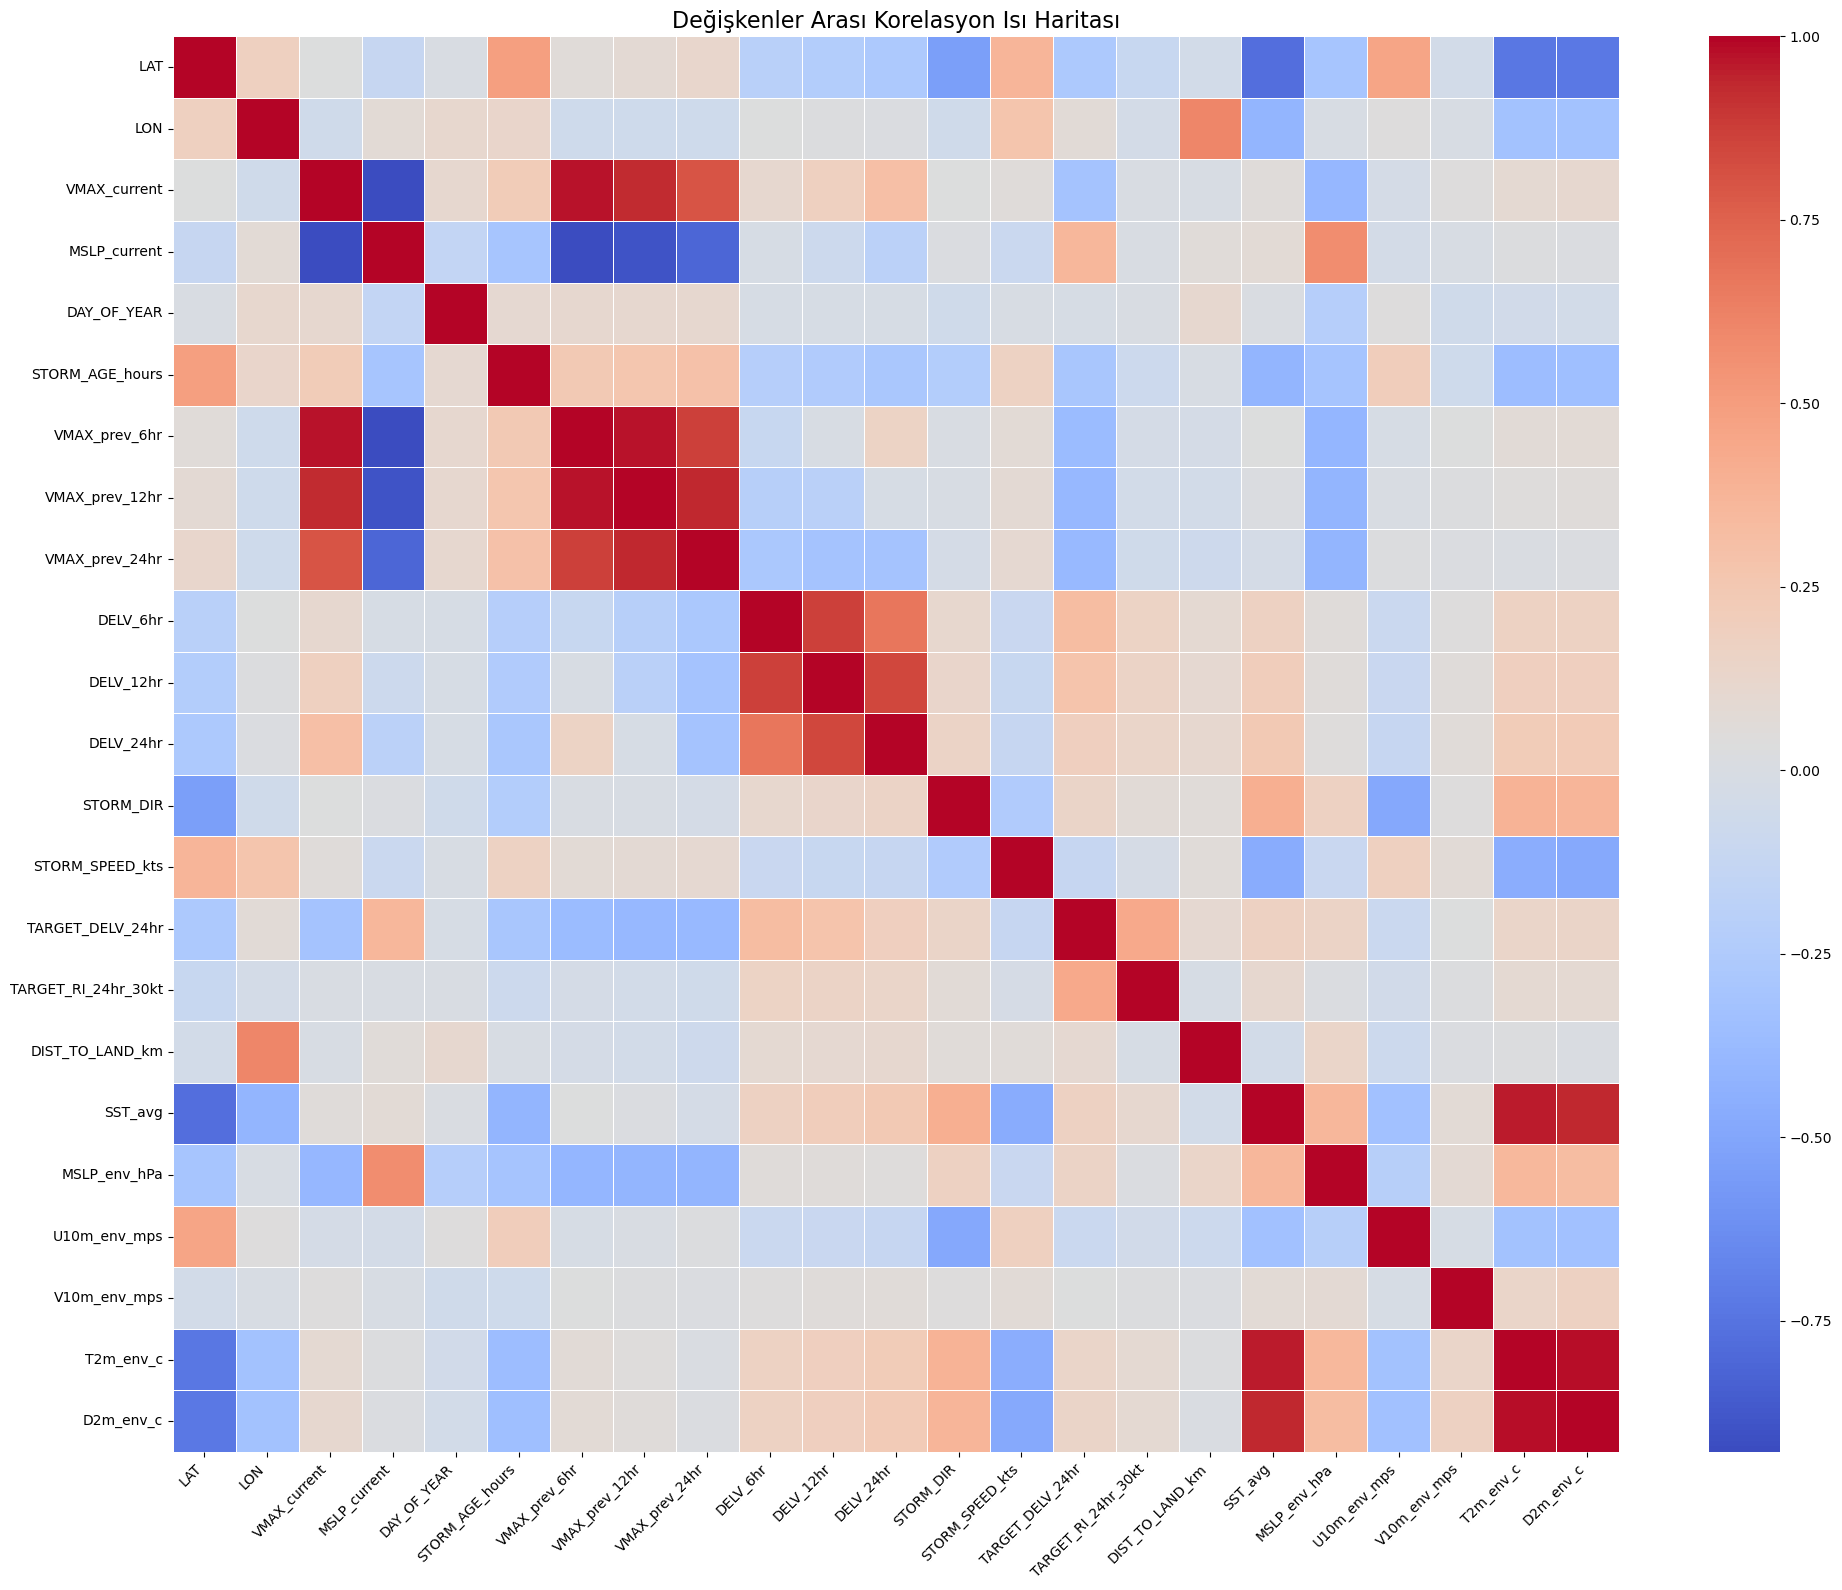

In [5]:
df = pd.read_csv("hurricanes_s11_env_dewpoint2m.csv")
plot_correlation_heatmap(df)

In [6]:
df_no_null = df.dropna()

In [7]:
df_no_null

,STORM_ID,STORM_NAME,TIMESTAMP,RECORD_ID,STATUS,LAT,LON,VMAX_current,MSLP_current,DAY_OF_YEAR,...,STORM_SPEED_kts,TARGET_DELV_24hr,TARGET_RI_24hr_30kt,DIST_TO_LAND_km,SST_avg,MSLP_env_hPa,U10m_env_mps,V10m_env_mps,T2m_env_c,D2m_env_c
3220,AL011994,ALBERTO,1994-07-03 15:00:00,L,TS,30.4,-86.5,55.0,993.0,184,...,10.588420,-35.0,0.0,4.370320,27.792356,1012.268896,-2.105632,1.375983,25.568597,23.085800
3249,AL011995,ALLISON,1995-06-05 14:00:00,L,TS,29.9,-84.4,60.0,991.0,156,...,11.926723,-25.0,0.0,0.893659,27.079781,1004.082051,-0.340982,-0.616763,24.847732,23.103001
3250,AL011995,ALLISON,1995-06-05 15:00:00,L,TS,30.1,-84.2,55.0,991.0,156,...,15.885210,-20.0,0.0,0.000000,27.403589,1004.239439,-0.763132,-0.474846,24.674480,23.028523
3282,AL011996,ARTHUR,1996-06-20 00:00:00,L,TS,34.7,-76.4,35.0,1005.0,172,...,10.928677,-5.0,0.0,3.871237,26.179387,1011.094771,4.281796,2.534886,25.312489,22.974334
3384,AL012001,ALLISON,2001-06-11 02:00:00,L,SD,29.6,-91.6,30.0,1004.0,162,...,23.681316,-5.0,0.0,3.190646,26.723382,1009.607463,2.156642,-0.327932,25.493265,22.608489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53994,AL212010,TOMAS,2010-11-06 07:30:00,L,TS,21.7,-71.6,60.0,992.0,310,...,14.129193,5.0,0.0,8.869669,28.038207,1007.136339,1.960908,-2.956376,26.605809,23.865798
54623,AL252005,WILMA,2005-10-21 21:45:00,L,HU,20.6,-86.8,130.0,927.0,294,...,5.032059,-30.0,0.0,3.416185,28.263925,994.673716,-4.871190,-1.619744,26.612757,24.593064
54625,AL252005,WILMA,2005-10-22 03:30:00,L,HU,20.8,-86.9,115.0,933.0,295,...,3.787615,-30.0,0.0,1.599274,28.245707,992.330097,-1.932618,3.497490,26.347265,24.359857
54635,AL252005,WILMA,2005-10-24 10:30:00,L,HU,25.9,-81.7,105.0,950.0,297,...,20.704235,-5.0,0.0,6.753675,26.676022,995.506859,1.796079,-2.682754,24.885747,21.797496


Korelasyon analizi için sayısal sütunlar seçiliyor...
Korelasyon matrisi hesaplanıyor...


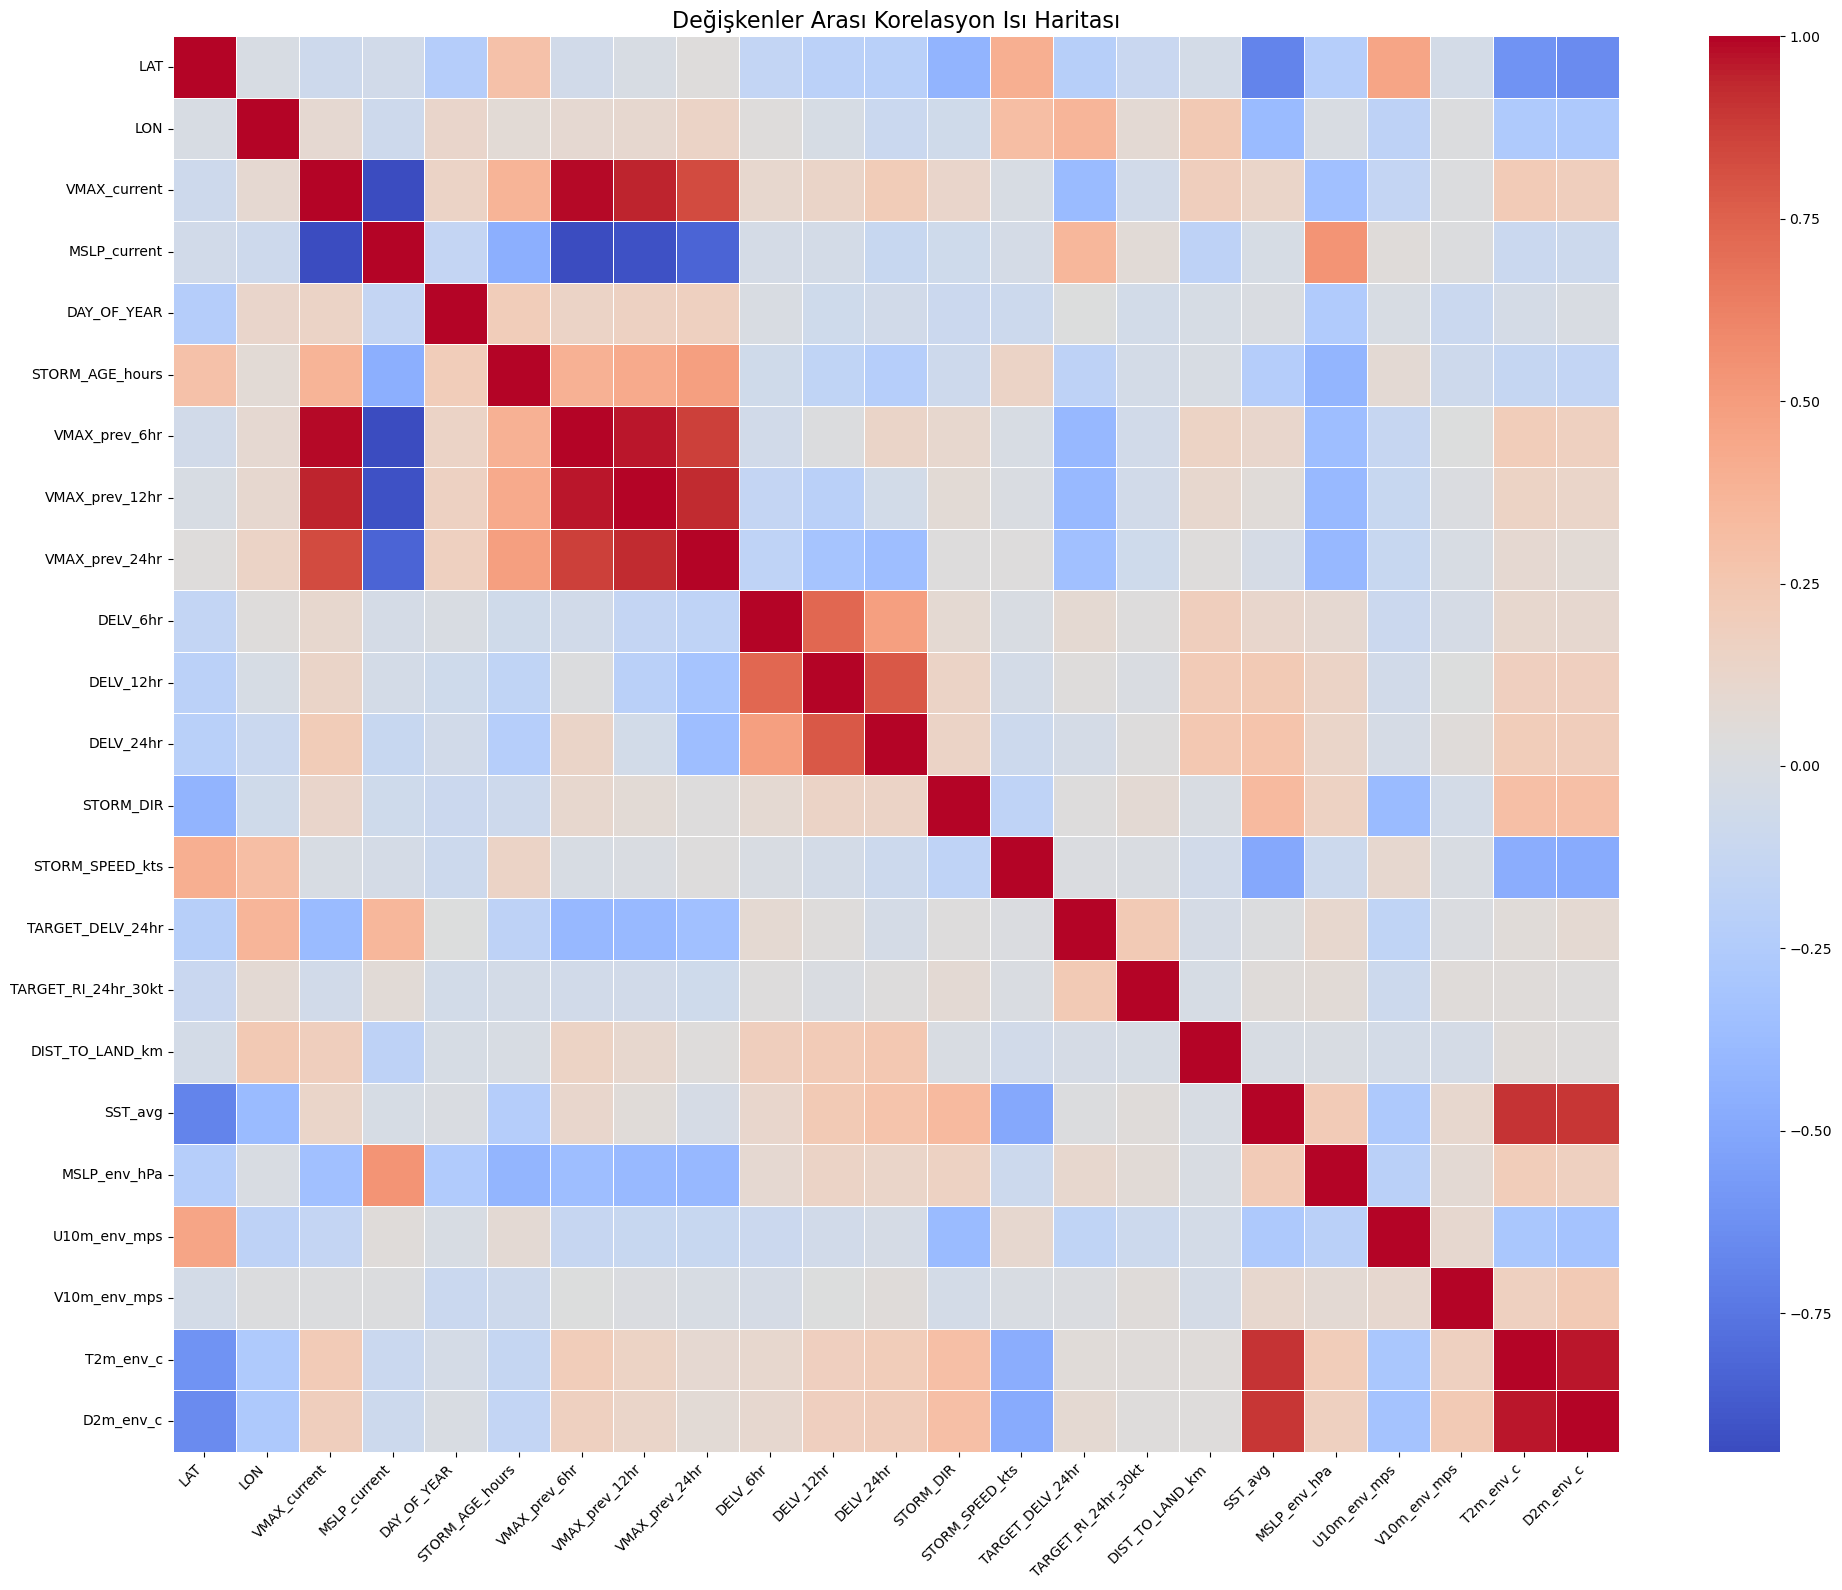

In [8]:
plot_correlation_heatmap(df_no_null)

'hurricanes_s11_env_dewpoint2m.csv' veri seti yükleniyor...
Keşifsel Veri Analizi (EDA) için saçılım grafikleri oluşturuluyor...
Hedef Değişken: TARGET_DELV_24hr


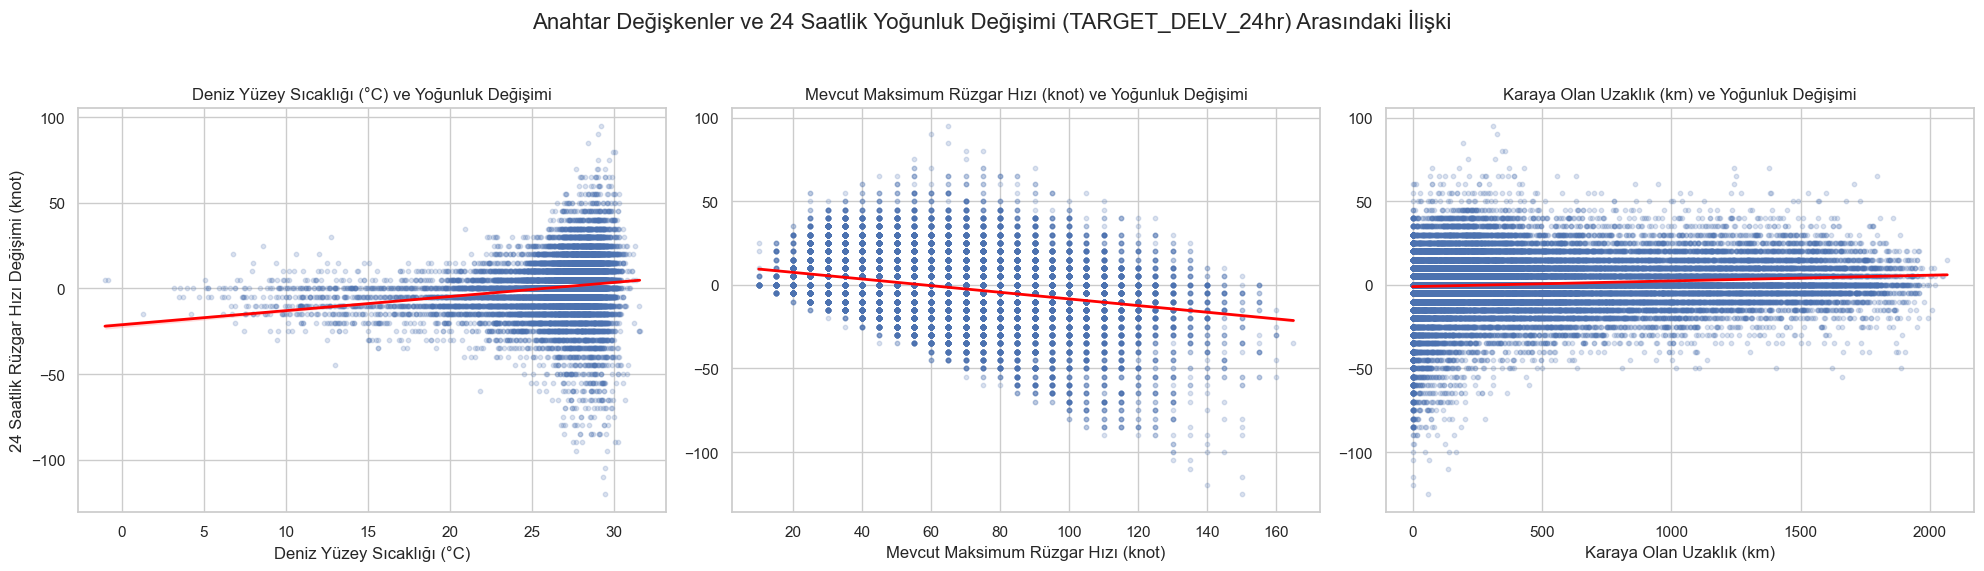

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_eda_scatter_plots(df, target_col='TARGET_DELV_24hr'):
    """
    Belirlenen anahtar tahmin ediciler ve hedef değişken arasında
    saçılım grafikleri (scatter plots) ve regresyon eğrileri çizer.

    Args:
        df (pandas.DataFrame): Analiz edilecek nihai DataFrame.
        target_col (str): Y ekseninde yer alacak hedef değişkenin sütun adı.
    """
    print(f"Keşifsel Veri Analizi (EDA) için saçılım grafikleri oluşturuluyor...")
    print(f"Hedef Değişken: {target_col}")

    # Grafik için kullanılacak tahmin edici değişkenleri belirle
    predictor_cols = {
        'SST_avg': 'Deniz Yüzey Sıcaklığı (°C)',
        'VMAX_current': 'Mevcut Maksimum Rüzgar Hızı (knot)',
        'DIST_TO_LAND_km': 'Karaya Olan Uzaklık (km)'
    }

    # Grafiğin stilini belirle
    sns.set_theme(style="whitegrid")

    # 3 grafiği yan yana çizmek için bir figür ve 1x3'lük bir subplot alanı oluştur
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(f"Anahtar Değişkenler ve 24 Saatlik Yoğunluk Değişimi ({target_col}) Arasındaki İlişki", fontsize=16)

    # DataFrame'de hedef sütunun varlığını kontrol et
    if target_col not in df.columns:
        print(f"HATA: Hedef sütun '{target_col}' DataFrame'de bulunamadı.")
        return
        
    # Tahmin edici sütunların varlığını kontrol et
    for col in predictor_cols.keys():
        if col not in df.columns:
            print(f"HATA: Tahmin edici sütun '{col}' DataFrame'de bulunamadı.")
            return

    # --- 1. Grafik: SST vs. Yoğunluk Değişimi ---
    ax1 = axes[0]
    sns.regplot(x='SST_avg', y=target_col, data=df,
                ax=ax1,
                scatter_kws={'alpha':0.2, 's':10},  # Noktaların şeffaflığı ve boyutu
                line_kws={'color':'red', 'linewidth':2}) # Regresyon çizgisinin rengi
    ax1.set_title(f'{predictor_cols["SST_avg"]} ve Yoğunluk Değişimi', fontsize=12)
    ax1.set_xlabel(predictor_cols['SST_avg'])
    ax1.set_ylabel('24 Saatlik Rüzgar Hızı Değişimi (knot)')

    # --- 2. Grafik: VMAX_current vs. Yoğunluk Değişimi ---
    ax2 = axes[1]
    sns.regplot(x='VMAX_current', y=target_col, data=df,
                ax=ax2,
                scatter_kws={'alpha':0.2, 's':10},
                line_kws={'color':'red', 'linewidth':2})
    ax2.set_title(f'{predictor_cols["VMAX_current"]} ve Yoğunluk Değişimi', fontsize=12)
    ax2.set_xlabel(predictor_cols['VMAX_current'])
    ax2.set_ylabel('') # Ortadaki grafiğin y-ekseni etiketini kaldır

    # --- 3. Grafik: DIST_TO_LAND_km vs. Yoğunluk Değişimi ---
    ax3 = axes[2]
    sns.regplot(x='DIST_TO_LAND_km', y=target_col, data=df,
                ax=ax3,
                scatter_kws={'alpha':0.2, 's':10},
                line_kws={'color':'red', 'linewidth':2})
    ax3.set_title(f'{predictor_cols["DIST_TO_LAND_km"]} ve Yoğunluk Değişimi', fontsize=12)
    ax3.set_xlabel(predictor_cols['DIST_TO_LAND_km'])
    ax3.set_ylabel('') # Sağdaki grafiğin y-ekseni etiketini kaldır

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ana başlığın sıkışmasını engelle
    
    # Grafiği kaydetmek isterseniz aşağıdaki satırın yorumunu kaldırın
    # output_filename = 'eda_scatter_plots.png'
    # plt.savefig(output_filename, dpi=300)
    # print(f"\nGrafik '{output_filename}' olarak kaydedildi.")
    
    plt.show()


# --- ANA KOD ---
# Projenizin en son ve tüm sütunları içeren CSV dosyasının adını buraya yazın.
# Dosya adının doğru olduğundan emin olun.
try:
    # Örnek dosya adı, siz kendinizinkini yazın
    final_data_path = 'hurricanes_s11_env_dewpoint2m.csv' 
    print(f"'{final_data_path}' veri seti yükleniyor...")
    df_final = pd.read_csv(final_data_path)
    
    # Grafik çizdirme fonksiyonunu çağır
    plot_eda_scatter_plots(df_final)
    
except FileNotFoundError:
    print(f"HATA: '{final_data_path}' dosyası bulunamadı. Lütfen dosya adını ve yolunu kontrol edin.")
except Exception as e:
    print(f"Bir hata oluştu: {e}")

'hurricanes_s11_env_dewpoint2m.csv' veri seti yükleniyor...
Hızlı Yoğunlaşma (RI) analizi için kutu grafikleri oluşturuluyor...
Hedef Değişken: TARGET_RI_24hr_30kt


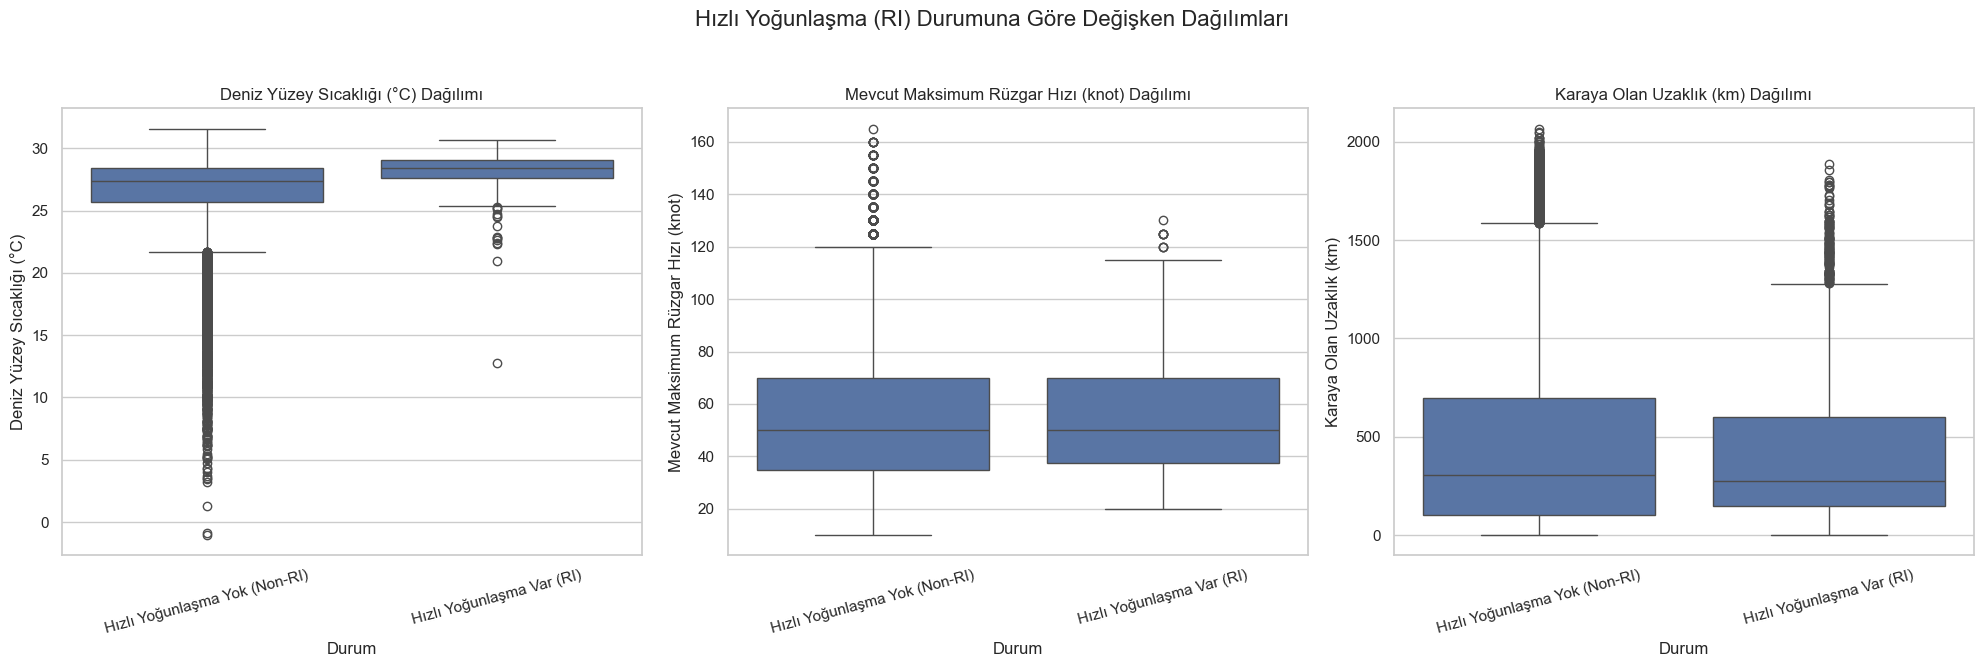

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_ri_analysis_boxplots(df, target_col='TARGET_RI_2hr_30kt'):
    """
    Hızlı Yoğunlaşma (RI) olan ve olmayan durumlar için anahtar tahmin edicilerin
    dağılımını karşılaştıran kutu grafikleri (box plots) çizer.

    Args:
        df (pandas.DataFrame): Analiz edilecek nihai DataFrame.
        target_col (str): Sınıflandırma hedef değişkeninin sütun adı.
    """
    print(f"Hızlı Yoğunlaşma (RI) analizi için kutu grafikleri oluşturuluyor...")
    print(f"Hedef Değişken: {target_col}")

    # Grafik için kullanılacak tahmin edici değişkenleri ve etiketlerini belirle
    predictor_cols = {
        'SST_avg': 'Deniz Yüzey Sıcaklığı (°C)',
        'VMAX_current': 'Mevcut Maksimum Rüzgar Hızı (knot)',
        'DIST_TO_LAND_km': 'Karaya Olan Uzaklık (km)'
    }
    
    # --- Veri Kontrolleri ---
    if target_col not in df.columns:
        # Orijinal sütun adınızda 24hr olabilir, onu da kontrol edelim.
        target_col_alt = 'TARGET_RI_24hr_30kt'
        if target_col_alt in df.columns:
            target_col = target_col_alt
            print(f"Uyarı: '{target_col}' bulunamadı, alternatif '{target_col_alt}' kullanılıyor.")
        else:
            print(f"HATA: Hedef sütun '{target_col}' veya '{target_col_alt}' DataFrame'de bulunamadı.")
            return
            
    for col in predictor_cols.keys():
        if col not in df.columns:
            print(f"HATA: Tahmin edici sütun '{col}' DataFrame'de bulunamadı.")
            return
            
    # Hedef değişkeni daha okunaklı hale getirelim (0 -> Non-RI, 1 -> RI)
    df[target_col + '_label'] = df[target_col].map({0: 'Hızlı Yoğunlaşma Yok (Non-RI)', 1: 'Hızlı Yoğunlaşma Var (RI)'})

    # Grafiğin stilini belirle
    sns.set_theme(style="whitegrid")

    # 3 grafiği yan yana çizmek için bir figür ve 1x3'lük bir subplot alanı oluştur
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    fig.suptitle(f"Hızlı Yoğunlaşma (RI) Durumuna Göre Değişken Dağılımları", fontsize=16)

    # --- 1. Grafik: SST Dağılımı ---
    ax1 = axes[0]
    sns.boxplot(x=target_col + '_label', y='SST_avg', data=df, ax=ax1)
    ax1.set_title(f'{predictor_cols["SST_avg"]} Dağılımı', fontsize=12)
    ax1.set_xlabel('Durum')
    ax1.set_ylabel(predictor_cols['SST_avg'])
    ax1.tick_params(axis='x', rotation=15)


    # --- 2. Grafik: VMAX_current Dağılımı ---
    ax2 = axes[1]
    sns.boxplot(x=target_col + '_label', y='VMAX_current', data=df, ax=ax2)
    ax2.set_title(f'{predictor_cols["VMAX_current"]} Dağılımı', fontsize=12)
    ax2.set_xlabel('Durum')
    ax2.set_ylabel(predictor_cols['VMAX_current'])
    ax2.tick_params(axis='x', rotation=15)

    # --- 3. Grafik: DIST_TO_LAND_km Dağılımı ---
    ax3 = axes[2]
    sns.boxplot(x=target_col + '_label', y='DIST_TO_LAND_km', data=df, ax=ax3)
    ax3.set_title(f'{predictor_cols["DIST_TO_LAND_km"]} Dağılımı', fontsize=12)
    ax3.set_xlabel('Durum')
    ax3.set_ylabel(predictor_cols['DIST_TO_LAND_km'])
    ax3.tick_params(axis='x', rotation=15)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Grafiği kaydetmek isterseniz aşağıdaki satırın yorumunu kaldırın
    # output_filename = 'eda_box_plots.png'
    # plt.savefig(output_filename, dpi=300)
    # print(f"\nGrafik '{output_filename}' olarak kaydedildi.")
    
    plt.show()


# --- ANA KOD ---
# Projenizin en son ve tüm sütunları içeren CSV dosyasının adını buraya yazın.
try:
    final_data_path = 'hurricanes_s11_env_dewpoint2m.csv' 
    print(f"'{final_data_path}' veri seti yükleniyor...")
    df_final = pd.read_csv(final_data_path)
    
    # Grafik çizdirme fonksiyonunu çağır
    # Sütun adınız 'TARGET_RI_24hr_30kt' ise kod bunu otomatik olarak bulacaktır.
    plot_ri_analysis_boxplots(df_final, target_col='TARGET_RI_24hr_30kt')
    
except FileNotFoundError:
    print(f"HATA: '{final_data_path}' dosyası bulunamadı. Lütfen dosya adını ve yolunu kontrol edin.")
except Exception as e:
    print(f"Bir hata oluştu: {e}")

'hurricanes_s11_env_dewpoint2m.csv' veri seti yükleniyor...
Hızlı Yoğunlaşma (RI) analizi için kutu grafikleri oluşturuluyor...
Hedef Değişken: TARGET_RI_24hr_30kt


C:\Users\aslay\AppData\Local\Temp\ipykernel_22632\2016847327.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col_name, data=df, ax=ax, palette="coolwarm")
C:\Users\aslay\AppData\Local\Temp\ipykernel_22632\2016847327.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col_name, data=df, ax=ax, palette="coolwarm")
C:\Users\aslay\AppData\Local\Temp\ipykernel_22632\2016847327.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col_name, data=df, ax=ax, palette="coolwarm")


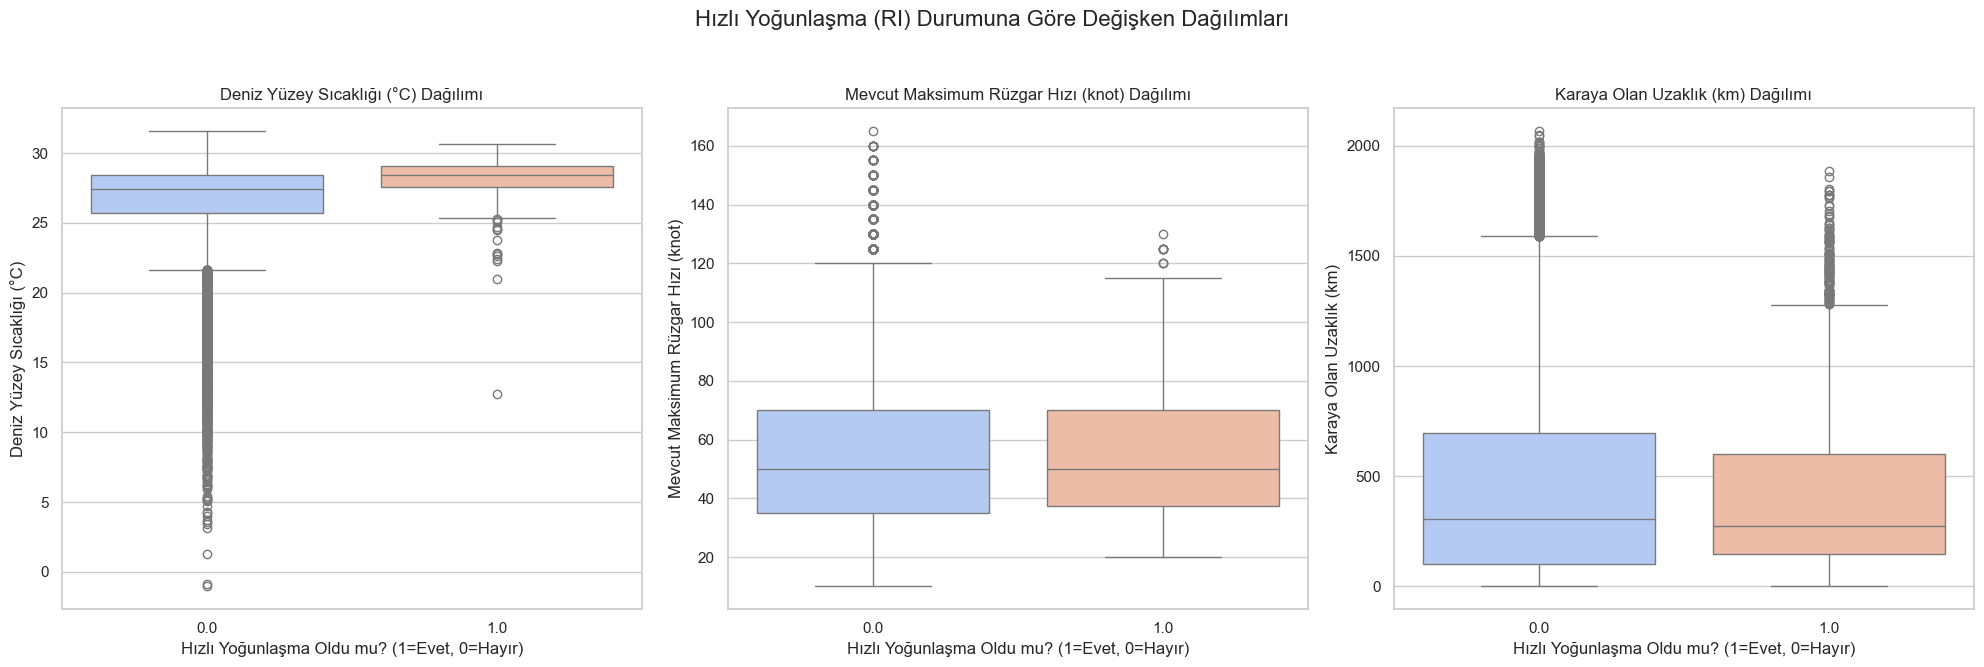

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_ri_boxplots(df, target_col='TARGET_RI_24hr_30kt'):
    """
    Hızlı Yoğunlaşma (RI) olan ve olmayan durumlar için anahtar tahmin edicilerin
    dağılımlarını kutu grafikleri (box plots) ile karşılaştırır.

    Args:
        df (pandas.DataFrame): Analiz edilecek nihai DataFrame.
        target_col (str): Sınıflandırma hedef değişkeninin sütun adı.
    """
    print(f"Hızlı Yoğunlaşma (RI) analizi için kutu grafikleri oluşturuluyor...")
    print(f"Hedef Değişken: {target_col}")

    # Grafik için kullanılacak tahmin edici değişkenleri ve etiketlerini belirle
    predictor_cols = {
        'SST_avg': 'Deniz Yüzey Sıcaklığı (°C)',
        'VMAX_current': 'Mevcut Maksimum Rüzgar Hızı (knot)',
        'DIST_TO_LAND_km': 'Karaya Olan Uzaklık (km)'
    }

    # Grafiğin stilini belirle
    sns.set_theme(style="whitegrid")

    # 3 grafiği yan yana çizmek için bir figür ve 1x3'lük bir subplot alanı oluştur
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    fig.suptitle(f"Hızlı Yoğunlaşma (RI) Durumuna Göre Değişken Dağılımları", fontsize=16)

    # DataFrame'de hedef sütunun varlığını kontrol et
    if target_col not in df.columns:
        print(f"HATA: Hedef sütun '{target_col}' DataFrame'de bulunamadı.")
        return
        
    # Tahmin edici sütunların varlığını kontrol et
    for col in predictor_cols.keys():
        if col not in df.columns:
            print(f"HATA: Tahmin edici sütun '{col}' DataFrame'de bulunamadı.")
            return

    # --- Grafik Döngüsü ---
    # Her bir tahmin edici için bir kutu grafiği çiz
    for ax, (col_name, col_label) in zip(axes, predictor_cols.items()):
        sns.boxplot(x=target_col, y=col_name, data=df, ax=ax, palette="coolwarm")
        ax.set_title(f'{col_label} Dağılımı', fontsize=12)
        ax.set_xlabel(f'Hızlı Yoğunlaşma Oldu mu? (1=Evet, 0=Hayır)')
        ax.set_ylabel(col_label)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Grafiği kaydetmek isterseniz aşağıdaki satırın yorumunu kaldırın
    # output_filename = 'eda_boxplot_plots.png'
    # plt.savefig(output_filename, dpi=300)
    # print(f"\nGrafik '{output_filename}' olarak kaydedildi.")
    
    plt.show()


# --- ANA KOD ---
# Projenizin en son ve tüm sütunları içeren CSV dosyasının adını buraya yazın.
try:
    final_data_path = 'hurricanes_s11_env_dewpoint2m.csv' 
    print(f"'{final_data_path}' veri seti yükleniyor...")
    df_final = pd.read_csv(final_data_path)
    
    # Grafik çizdirme fonksiyonunu çağır
    plot_ri_boxplots(df_final)
    
except FileNotFoundError:
    print(f"HATA: '{final_data_path}' dosyası bulunamadı. Lütfen dosya adını ve yolunu kontrol edin.")
except Exception as e:
    print(f"Bir hata oluştu: {e}")

'hurricanes_s11_env_dewpoint2m.csv' veri seti yükleniyor...
Hedef değişken dağılımları oluşturuluyor...


C:\Users\aslay\AppData\Local\Temp\ipykernel_22632\966617473.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=classification_target, data=df, ax=ax2, palette="coolwarm")


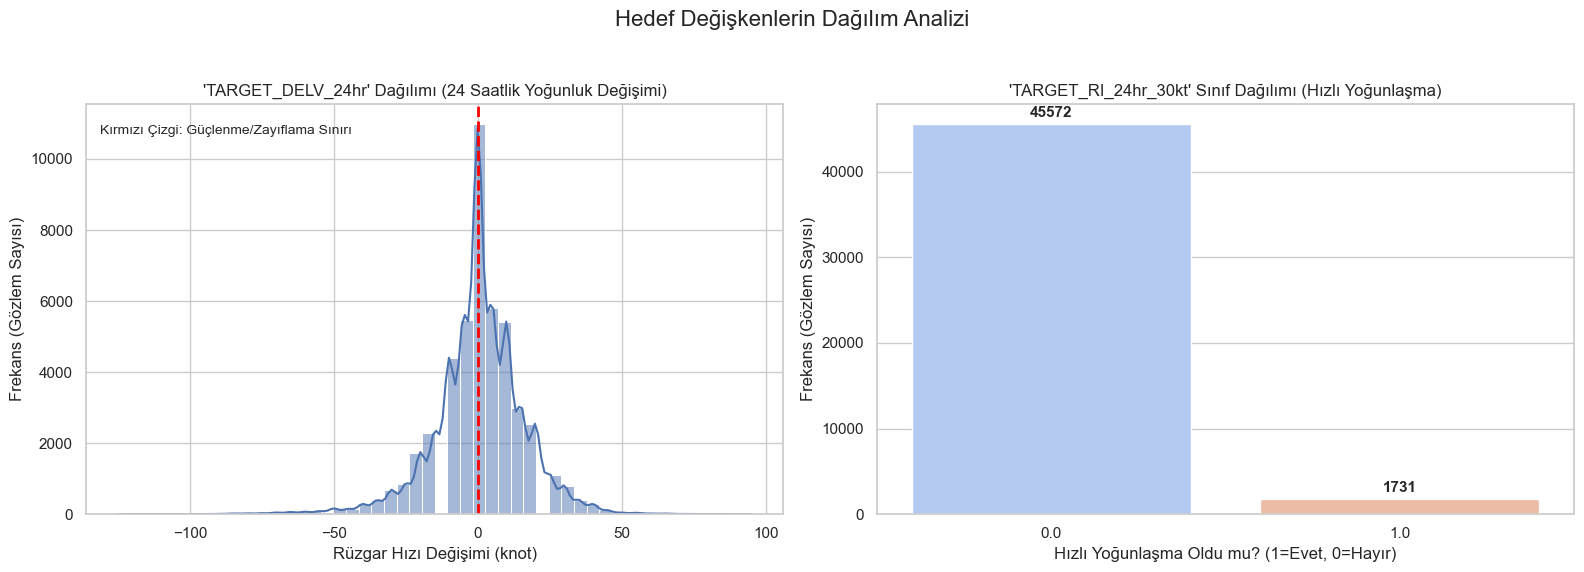

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_target_distributions(df, regression_target='TARGET_DELV_24hr', classification_target='TARGET_RI_24hr_30kt'):
    """
    Regresyon ve sınıflandırma hedef değişkenlerinin dağılımlarını görselleştirir.

    Args:
        df (pandas.DataFrame): Analiz edilecek nihai DataFrame.
        regression_target (str): Sürekli hedef değişkenin sütun adı.
        classification_target (str): Kategorik (ikili) hedef değişkenin sütun adı.
    """
    print("Hedef değişken dağılımları oluşturuluyor...")

    # DataFrame'de sütunların varlığını kontrol et
    if regression_target not in df.columns or classification_target not in df.columns:
        print(f"HATA: Gerekli hedef sütunlar ('{regression_target}', '{classification_target}') DataFrame'de bulunamadı.")
        return

    # Grafiğin stilini belirle
    sns.set_theme(style="whitegrid")

    # 2 grafiği yan yana çizmek için bir figür ve 1x2'lik bir subplot alanı oluştur
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle("Hedef Değişkenlerin Dağılım Analizi", fontsize=16)

    # --- 1. Grafik: Regresyon Hedefi Dağılımı (Histogram) ---
    ax1 = axes[0]
    sns.histplot(df[regression_target].dropna(), kde=True, ax=ax1, bins=50)
    ax1.axvline(0, color='red', linestyle='--', linewidth=2) # Sıfır noktasını belirt
    ax1.set_title(f"'{regression_target}' Dağılımı (24 Saatlik Yoğunluk Değişimi)", fontsize=12)
    ax1.set_xlabel('Rüzgar Hızı Değişimi (knot)')
    ax1.set_ylabel('Frekans (Gözlem Sayısı)')
    ax1.text(0.02, 0.95, 'Kırmızı Çizgi: Güçlenme/Zayıflama Sınırı', transform=ax1.transAxes, fontsize=10, verticalalignment='top')


    # --- 2. Grafik: Sınıflandırma Hedefi Dağılımı (Count Plot) ---
    ax2 = axes[1]
    # Sınıflandırma hedefindeki etiketlerin olduğundan emin olalım
    class_counts = df[classification_target].value_counts()
    
    if not class_counts.empty:
        sns.countplot(x=classification_target, data=df, ax=ax2, palette="coolwarm")
        ax2.set_title(f"'{classification_target}' Sınıf Dağılımı (Hızlı Yoğunlaşma)", fontsize=12)
        ax2.set_xlabel('Hızlı Yoğunlaşma Oldu mu? (1=Evet, 0=Hayır)')
        ax2.set_ylabel('Frekans (Gözlem Sayısı)')
        
        # Barların üzerine sayıları yazdır
        for i, count in enumerate(class_counts.sort_index()):
            ax2.text(i, count + (class_counts.max() * 0.01), str(count), ha='center', va='bottom', fontsize=11, weight='bold')
    else:
        ax2.set_title("Sınıflandırma hedefi verisi bulunamadı.")


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Grafiği kaydetmek isterseniz aşağıdaki satırın yorumunu kaldırın
    # output_filename = 'eda_target_distributions.png'
    # plt.savefig(output_filename, dpi=300)
    # print(f"\nGrafik '{output_filename}' olarak kaydedildi.")
    
    plt.show()

# --- ANA KOD ---
# Projenizin en son ve tüm sütunları içeren CSV dosyasının adını buraya yazın.
try:
    final_data_path = 'hurricanes_s11_env_dewpoint2m.csv' 
    print(f"'{final_data_path}' veri seti yükleniyor...")
    df_final = pd.read_csv(final_data_path)
    
    # Grafik çizdirme fonksiyonunu çağır
    plot_target_distributions(df_final)
    
except FileNotFoundError:
    print(f"HATA: '{final_data_path}' dosyası bulunamadı. Lütfen dosya adını ve yolunu kontrol edin.")
except Exception as e:
    print(f"Bir hata oluştu: {e}")

'hurricanes_s11_env_dewpoint2m.csv' veri seti yükleniyor...

--- 'TARGET_DELV_24hr' ile Korelasyon Analizi ---
Korelasyon Değerleri (En Yüksekten En Düşüğe):
TARGET_RI_24hr_30kt    0.440062
MSLP_current           0.361251
DELV_6hr               0.325079
DELV_12hr              0.279680
DELV_24hr              0.188040
SST_avg                0.174080
MSLP_env_hPa           0.152331
STORM_DIR              0.144248
D2m_env_c              0.142601
T2m_env_c              0.138793
DIST_TO_LAND_km        0.101581
LON                    0.066243
V10m_env_mps           0.029329
DAY_OF_YEAR           -0.014291
U10m_env_mps          -0.096261
STORM_SPEED_kts       -0.120177
LAT                   -0.269224
STORM_AGE_hours       -0.288294
VMAX_current          -0.317295
VMAX_prev_6hr         -0.370978
VMAX_prev_24hr        -0.380949
VMAX_prev_12hr        -0.390691
Name: TARGET_DELV_24hr, dtype: float64


C:\Users\aslay\AppData\Local\Temp\ipykernel_22632\191861376.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_correlations.values, y=target_correlations.index, palette="vlag")


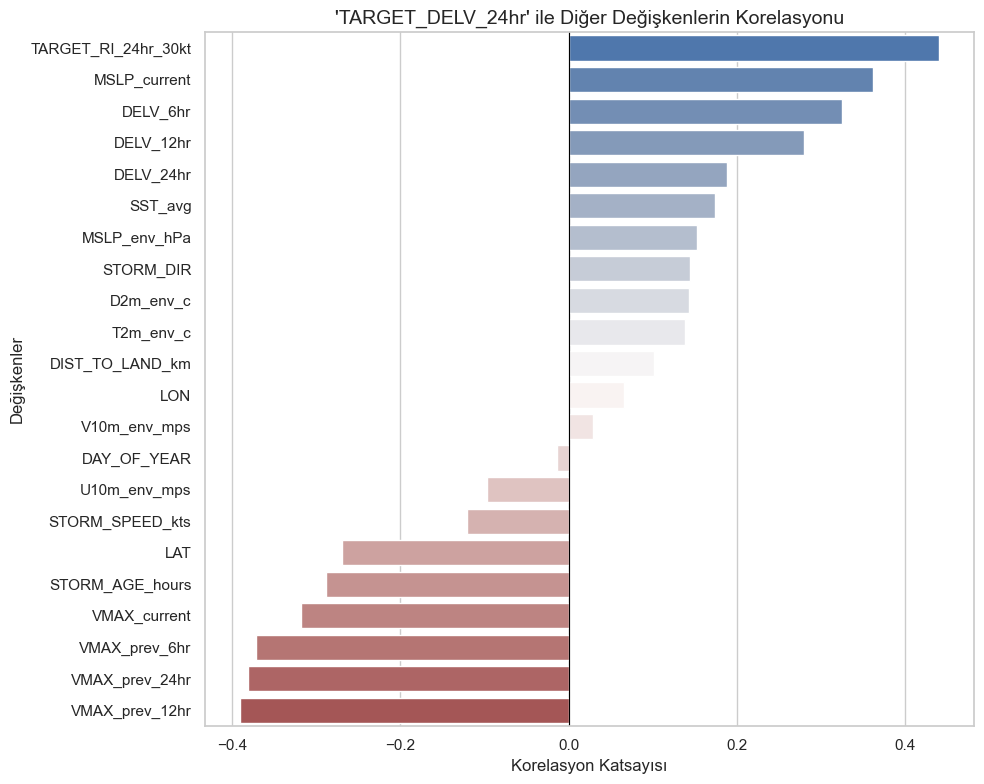


--- 'TARGET_RI_24hr_30kt' ile Korelasyon Analizi ---
Korelasyon Değerleri (En Yüksekten En Düşüğe):
TARGET_DELV_24hr    0.440062
DELV_6hr            0.157049
DELV_12hr           0.151705
DELV_24hr           0.135231
SST_avg             0.109719
D2m_env_c           0.093801
T2m_env_c           0.091792
STORM_DIR           0.071524
V10m_env_mps        0.027679
MSLP_env_hPa        0.014771
VMAX_current        0.005427
DAY_OF_YEAR         0.004813
MSLP_current        0.003327
DIST_TO_LAND_km    -0.012715
STORM_SPEED_kts    -0.019424
VMAX_prev_6hr      -0.024910
LON                -0.039547
VMAX_prev_12hr     -0.043877
U10m_env_mps       -0.052963
VMAX_prev_24hr     -0.061609
STORM_AGE_hours    -0.079083
LAT                -0.110388
Name: TARGET_RI_24hr_30kt, dtype: float64


C:\Users\aslay\AppData\Local\Temp\ipykernel_22632\191861376.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_correlations.values, y=target_correlations.index, palette="vlag")


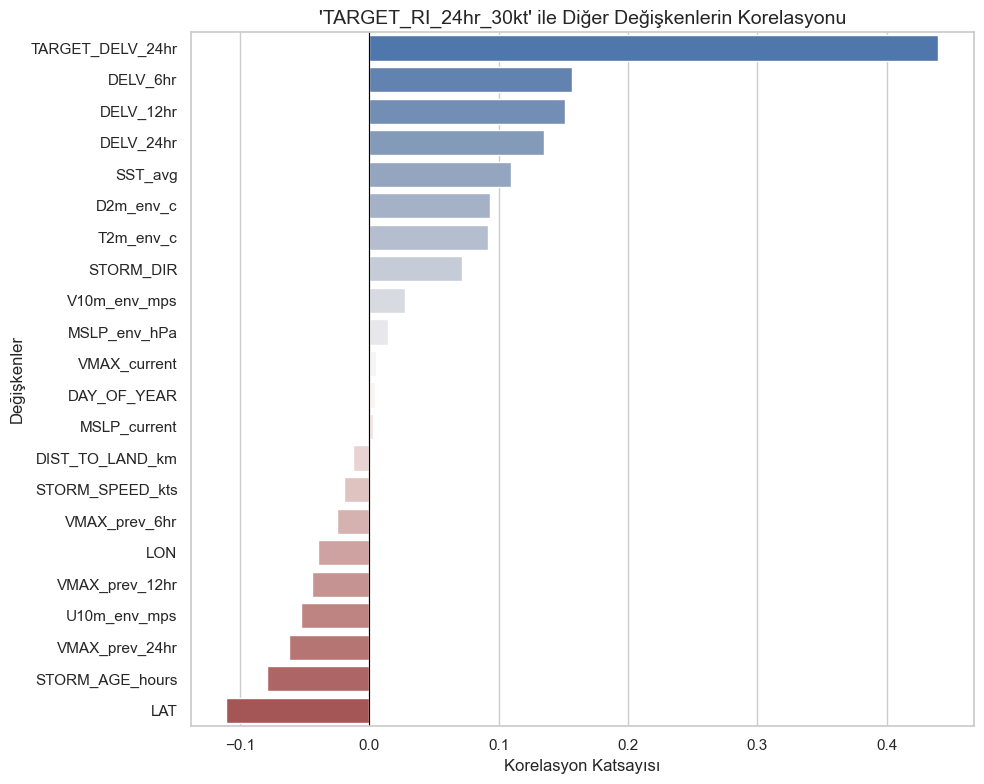

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_target_correlations(df, target_col):
    """
    Belirtilen bir hedef değişkene göre diğer tüm sayısal değişkenlerin
    korelasyonunu hesaplar, sıralar ve bir çubuk grafiği ile görselleştirir.

    Args:
        df (pandas.DataFrame): Analiz edilecek nihai DataFrame.
        target_col (str): Korelasyonun hesaplanacağı hedef değişkenin sütun adı.
    """
    print(f"\n--- '{target_col}' ile Korelasyon Analizi ---")

    # DataFrame'de hedef sütunun varlığını kontrol et
    if target_col not in df.columns:
        print(f"HATA: Hedef sütun '{target_col}' DataFrame'de bulunamadı.")
        return

    # Sadece sayısal sütunları al ve korelasyonu hesapla
    numeric_df = df.select_dtypes(include=np.number)
    corr_matrix = numeric_df.corr()

    # Hedef değişkenle olan korelasyonları al, NaN değerleri at ve sırala
    target_correlations = corr_matrix[target_col].dropna().sort_values(ascending=False)

    # Hedefin kendisiyle olan korelasyonunu (her zaman 1.0'dir) listeden çıkar
    target_correlations = target_correlations.drop(target_col)

    print("Korelasyon Değerleri (En Yüksekten En Düşüğe):")
    print(target_correlations)

    # Görselleştirme
    plt.figure(figsize=(10, 8))
    sns.barplot(x=target_correlations.values, y=target_correlations.index, palette="vlag")
    plt.title(f"'{target_col}' ile Diğer Değişkenlerin Korelasyonu", fontsize=14)
    plt.xlabel("Korelasyon Katsayısı")
    plt.ylabel("Değişkenler")
    plt.axvline(0, color='black', linewidth=0.8) # Sıfır çizgisini ekle
    plt.tight_layout()
    plt.show()


# --- ANA KOD ---
# Projenizin en son ve tüm sütunları içeren CSV dosyasının adını buraya yazın.
try:
    final_data_path = 'hurricanes_s11_env_dewpoint2m.csv' 
    print(f"'{final_data_path}' veri seti yükleniyor...")
    df_final = pd.read_csv(final_data_path)
    
    # Regresyon hedefi için korelasyonları çizdir
    plot_target_correlations(df_final, target_col='TARGET_DELV_24hr')
    
    # Sınıflandırma hedefi için korelasyonları çizdir
    plot_target_correlations(df_final, target_col='TARGET_RI_24hr_30kt')
    
except FileNotFoundError:
    print(f"HATA: '{final_data_path}' dosyası bulunamadı. Lütfen dosya adını ve yolunu kontrol edin.")
except Exception as e:
    print(f"Bir hata oluştu: {e}")

'hurricanes_s11_env_dewpoint2m.csv' veri seti yükleniyor...

--- 'TARGET_DELV_24hr' ile Korelasyon Analizi ---
Korelasyon Değerleri (En Yüksekten En Düşüğe):
TARGET_RI_24hr_30kt    0.440062
MSLP_current           0.361251
DELV_6hr               0.325079
DELV_12hr              0.279680
DELV_24hr              0.188040
SST_avg                0.174080
MSLP_env_hPa           0.152331
STORM_DIR              0.144248
D2m_env_c              0.142601
T2m_env_c              0.138793
DIST_TO_LAND_km        0.101581
LON                    0.066243
V10m_env_mps           0.029329
DAY_OF_YEAR           -0.014291
U10m_env_mps          -0.096261
STORM_SPEED_kts       -0.120177
LAT                   -0.269224
STORM_AGE_hours       -0.288294
VMAX_current          -0.317295
VMAX_prev_6hr         -0.370978
VMAX_prev_24hr        -0.380949
VMAX_prev_12hr        -0.390691
Name: TARGET_DELV_24hr, dtype: float64


C:\Users\aslay\AppData\Local\Temp\ipykernel_22632\2894588243.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_correlations.values, y=target_correlations.index, palette="vlag")


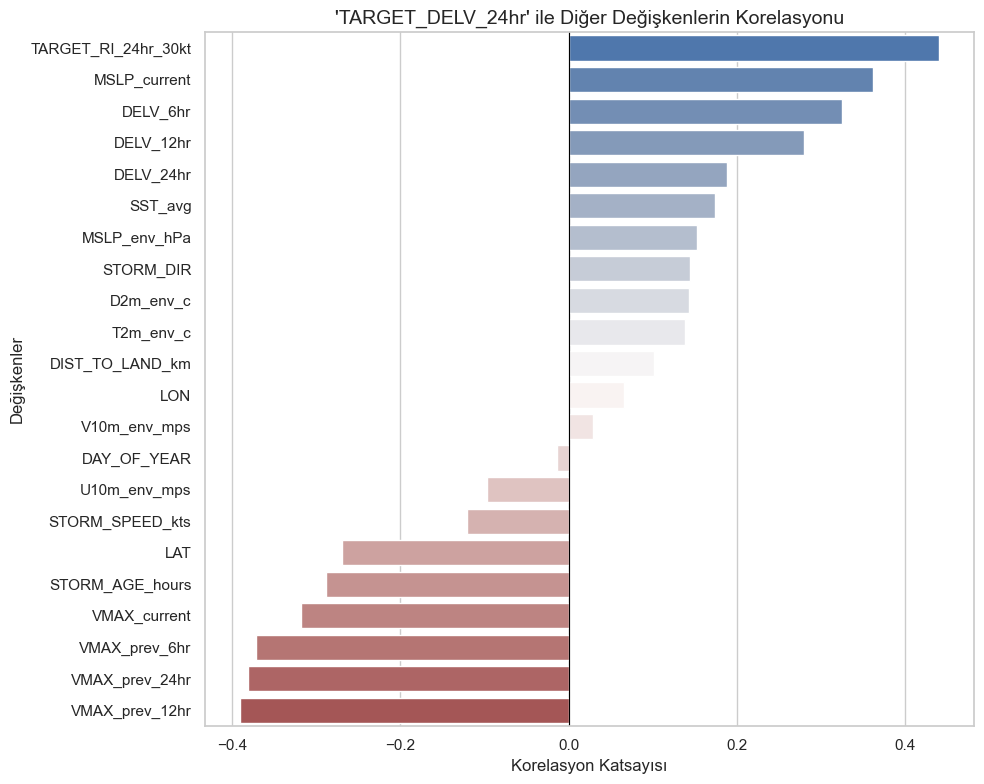


--- 'TARGET_RI_24hr_30kt' ile Korelasyon Analizi ---
Korelasyon Değerleri (En Yüksekten En Düşüğe):
TARGET_DELV_24hr    0.440062
DELV_6hr            0.157049
DELV_12hr           0.151705
DELV_24hr           0.135231
SST_avg             0.109719
D2m_env_c           0.093801
T2m_env_c           0.091792
STORM_DIR           0.071524
V10m_env_mps        0.027679
MSLP_env_hPa        0.014771
VMAX_current        0.005427
DAY_OF_YEAR         0.004813
MSLP_current        0.003327
DIST_TO_LAND_km    -0.012715
STORM_SPEED_kts    -0.019424
VMAX_prev_6hr      -0.024910
LON                -0.039547
VMAX_prev_12hr     -0.043877
U10m_env_mps       -0.052963
VMAX_prev_24hr     -0.061609
STORM_AGE_hours    -0.079083
LAT                -0.110388
Name: TARGET_RI_24hr_30kt, dtype: float64


C:\Users\aslay\AppData\Local\Temp\ipykernel_22632\2894588243.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_correlations.values, y=target_correlations.index, palette="vlag")


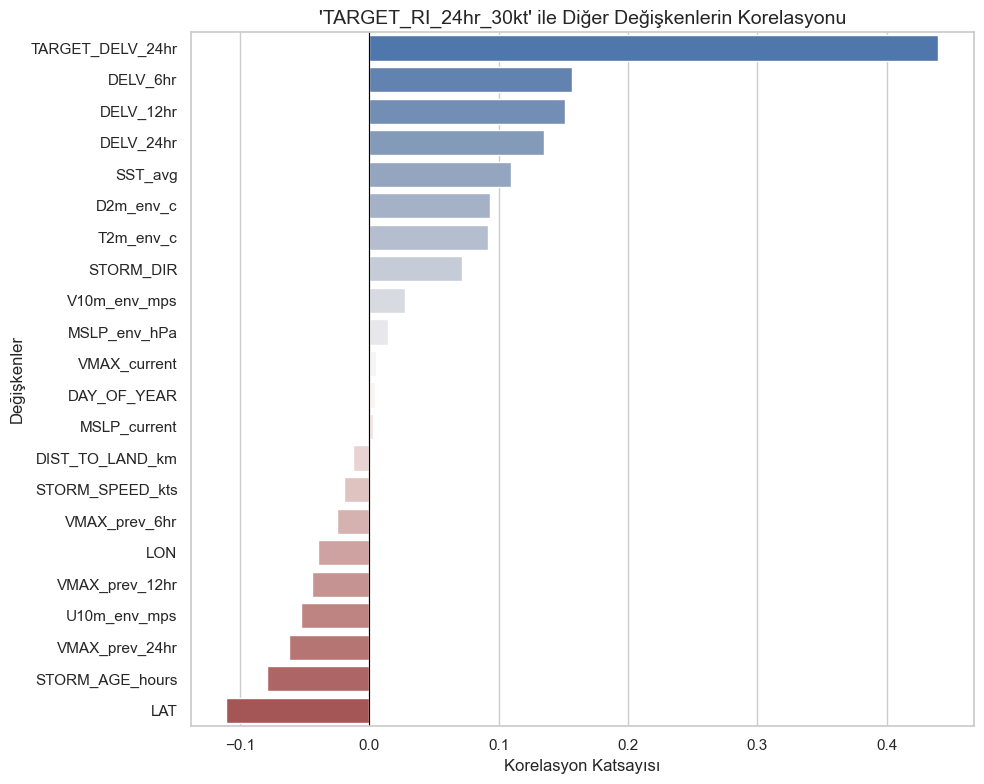

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_target_correlations(df_no_null, target_col):
    """
    Belirtilen bir hedef değişkene göre diğer tüm sayısal değişkenlerin
    korelasyonunu hesaplar, sıralar ve bir çubuk grafiği ile görselleştirir.

    Args:
        df (pandas.DataFrame): Analiz edilecek nihai DataFrame.
        target_col (str): Korelasyonun hesaplanacağı hedef değişkenin sütun adı.
    """
    print(f"\n--- '{target_col}' ile Korelasyon Analizi ---")

    # DataFrame'de hedef sütunun varlığını kontrol et
    if target_col not in df.columns:
        print(f"HATA: Hedef sütun '{target_col}' DataFrame'de bulunamadı.")
        return

    # Sadece sayısal sütunları al ve korelasyonu hesapla
    numeric_df = df.select_dtypes(include=np.number)
    corr_matrix = numeric_df.corr()

    # Hedef değişkenle olan korelasyonları al, NaN değerleri at ve sırala
    target_correlations = corr_matrix[target_col].dropna().sort_values(ascending=False)

    # Hedefin kendisiyle olan korelasyonunu (her zaman 1.0'dir) listeden çıkar
    target_correlations = target_correlations.drop(target_col)

    print("Korelasyon Değerleri (En Yüksekten En Düşüğe):")
    print(target_correlations)

    # Görselleştirme
    plt.figure(figsize=(10, 8))
    sns.barplot(x=target_correlations.values, y=target_correlations.index, palette="vlag")
    plt.title(f"'{target_col}' ile Diğer Değişkenlerin Korelasyonu", fontsize=14)
    plt.xlabel("Korelasyon Katsayısı")
    plt.ylabel("Değişkenler")
    plt.axvline(0, color='black', linewidth=0.8) # Sıfır çizgisini ekle
    plt.tight_layout()
    plt.show()


# --- ANA KOD ---
# Projenizin en son ve tüm sütunları içeren CSV dosyasının adını buraya yazın.
try:
    final_data_path = 'hurricanes_s11_env_dewpoint2m.csv' 
    print(f"'{final_data_path}' veri seti yükleniyor...")
    df_final = pd.read_csv(final_data_path)
    
    # Regresyon hedefi için korelasyonları çizdir
    plot_target_correlations(df_final, target_col='TARGET_DELV_24hr')
    
    # Sınıflandırma hedefi için korelasyonları çizdir
    plot_target_correlations(df_final, target_col='TARGET_RI_24hr_30kt')
    
except FileNotFoundError:
    print(f"HATA: '{final_data_path}' dosyası bulunamadı. Lütfen dosya adını ve yolunu kontrol edin.")
except Exception as e:
    print(f"Bir hata oluştu: {e}")